In [1]:
# (C) Copyright 1996- ECMWF.
#
# This software is licensed under the terms of the Apache Licence Version 2.0
# which can be obtained at http://www.apache.org/licenses/LICENSE-2.0.
# In applying this licence, ECMWF does not waive the privileges and immunities
# granted to it by virtue of its status as an intergovernmental organisation
# nor does it submit to any jurisdiction.

In [2]:
# basic libraries for data analysis
import numpy as np 
import pandas as pd
import geopandas as gpd
import xarray as xr

from itertools import product

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap
from matplotlib.dates import DateFormatter
from matplotlib.image import imread
import seaborn as sns
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import AxesGrid # for multiplots and nice mixing with cartopy
from cartopy.mpl.geoaxes import GeoAxes # for adding cartopy attributes to subplots
import rioxarray as rxr

# plotting functions
from matplotlib import rc

# the below two are needed cause tif files are too large to be read otherwise
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [3]:
rc('font', size=8)
rc('axes', labelsize=8, linewidth=0.2)
rc('legend', fontsize=6)
rc('xtick', labelsize=6)
rc('ytick', labelsize=6)
rc('lines', lw=0.5, mew=0.4)
rc('grid', linewidth=0.2)
rc('xtick.major', width=0.25)
rc('ytick.major', width=0.25)

sns.set_palette('colorblind') # change the default patette to colorblind-friendly

## Input variables

In [4]:
out_dir = ''

season_studied = 'Winter' # All, Winter or Summer!
observational_dataset = 'EOBS' # ERA5 or EOBS
rolling_days = 3 # what temporal resolution to analyse? in number of days; integer>=1

In [1]:
aux_name = f'{observational_dataset}_{season_studied}_Days{rolling_days}'
results_used = f'{aux_name}/Statistics_{aux_name}_Bootstraps_FullAreas_Data/'
plots_loc = results_used[:-5]+'Plots/'
!mkdir $out_dir$plots_loc

del(aux_name)

In [6]:
warn_areas_Calabria = gpd.read_file('zip://../Shapefiles/Calabria/WarningAreas.zip')
warn_areas_Calabria = warn_areas_Calabria.drop(columns=['id']) # keep only columns of interest
local_pat_domain_Calabria = [52, -4, 29, 25]
warn_areas_ordered = [4, 6, 1, 3, 2, 5, 7, 0, 8]

## Create final format of shapefiles and data needed per analysed area

In [7]:
def prepros_shpf(shapefile_input):
    
    output_shp = shapefile_input.to_crs("EPSG:4326") # convert to lat/lon coordinate system 
    output_shp.columns = ['name_area', 'geometry'] # change names of columns for consistency

    output_shp['Area'] = len(output_shp)
    areal_full = output_shp.dissolve(by='Area')
    areal_full.name_area = 'Full'
    output_shp = pd.concat([output_shp, areal_full]).drop(columns='Area')
    
    # find boundary for gridded data based on the warning areas (& add 0.1 degree extra boundary for security)
    total_bounds = output_shp.total_bounds
    total_bounds = [np.floor(i)-.1 if count in [0, 1] else np.ceil(i)+.1 for count, i in enumerate(total_bounds)]
    
    return [output_shp, total_bounds]

In [8]:
# # dictionary of names with the subdomains used. For each key, give the following data:
# 1. warning areas, 2. precipitation subdomain, 3. localized subdomain for patterns
domains_used = {'Calabria': prepros_shpf(warn_areas_Calabria)+[local_pat_domain_Calabria],
                }

del(warn_areas_Calabria, local_pat_domain_Calabria)

In [9]:
types_used_all = ['MedPat.', 'WVF', 'RH850', 'WVF + RH850', 'Precip.', 'Local Pred.']
color_palette = {i: j for i, j in zip(types_used_all, sns.color_palette()[:len(types_used_all)])}    

pat_names = ['Atlantic Low', 'Biscay Low', 'Iberian Low', 'Sicilian Low', 'Balkan Low', 'Black Sea Low',
             'Mediterranean High', 'Minor Low', 'Minor High'] # naming of patterns
pat_names_short = ['AtlL', 'BscL', 'IbrL', 'SclL', 'BlkL', 'BlSL', 'MedH', 'MnrL', 'MnrH'] # short names 
pat_colors = [(.02, 0.40, 0.55), (.0, 0.75, 0.7), (.0, 0.63, 0.4), (.85, 0.35, 0.1), (.8, 0.5, 0.75), 
              (.7, 0.5, 0.45), (1, 0.7, 0.75), (.65, 0.65, 0.65), (.95, 0.95, 0.2)]

wvf_directions_symbols = {'WestW': '<', 'EastW': '>', 'SouthW': 'v', 'NorthW': '^', 
                          'Total': 'P', 'RH850': '*', 'Alone': ''}

markers_symbols = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'X'] # for patterns and predictors

subplot_id = list(map(chr, range(97, 123)))# letters for subplots titles

## Predictors and EPEs connections

In [10]:
all_files = !ls $out_dir$results_used
areas_used = sorted(list(set([i.split('_')[0] for i in all_files])))
areas_used = [i for i in areas_used if i != 'Med'] # Med is only used for all parts of the analysis
print(areas_used)
methods_used = sorted(list(set([i.split('_')[1] for i in all_files])))
sets_used = sorted(list(set([i.split('_')[2] for i in all_files])))
sets_used = [i for i in sets_used if 'Forecast' not in i]

['Calabria']


In [11]:
results_all = {i_key: {} for i_key in areas_used} # generate dictionary for storing all results

In [12]:
for i_dom in results_all:
    results_all[i_dom] = {i_type: {} for i_type in methods_used}
    for i_type in results_all[i_dom]:
        results_all[i_dom][i_type] = {}
        for i_key in sets_used:
            data_to_read = f'{out_dir}{results_used}{i_dom}_{i_type}_{i_key}'
            file_exist = !ls $data_to_read && echo yes
            if len(file_exist)==2: # if len is 2, then it means that file exists
                results_all[i_dom][i_type][i_key[:-3]] = xr.open_dataset(data_to_read) #i_key[:-3] so rmv '.nc'
                if i_key in ['Timeseries.nc', 'Labels.nc', 'Congruence.nc']:
                    data_aux = results_all[i_dom][i_type][i_key[:-3]]
                    data_aux = data_aux.isel(time=range(0, len(data_aux.time), rolling_days))
                    results_all[i_dom][i_type][i_key[:-3]] = data_aux

# get auxiliary data needed for various plots and data analysis
perc_used = list(results_all[i_dom][i_type]['Brier'].percentile.values) # get the EPEs thresholds of the analysis
perc_used = sorted(perc_used) # just for reassurance

del(i_dom, i_type, i_key, data_to_read, file_exist, data_aux, sets_used, all_files, methods_used)

In [2]:
for i_dom in results_all:
    !mkdir $out_dir$plots_loc$i_dom
    
del(i_dom)

In [14]:
eobs_locs = pd.read_csv('Eobs_All.csv')

stations_year = pd.DataFrame(index=eobs_locs['#STATION'])
for i in range(1979, 2020):
    stations_year[i] = np.nan
    for j in range(len(stations_year)):
        if pd.to_datetime(eobs_locs.iloc[j, 6])<=pd.to_datetime(f'{i}0401'):
            if pd.to_datetime(eobs_locs.iloc[j, 7])>=pd.to_datetime(f'{i}0801'):
                stations_year.loc[stations_year.index[j], i] = 1
    
print('Summary statistics for number of stations per year:\n', stations_year.sum().describe())
del(eobs_locs, stations_year, i, j)

Summary statistics for number of stations per year:
 count     41.000000
mean     119.560976
std       11.412819
min       86.000000
25%      115.000000
50%      126.000000
75%      126.000000
max      126.000000
dtype: float64


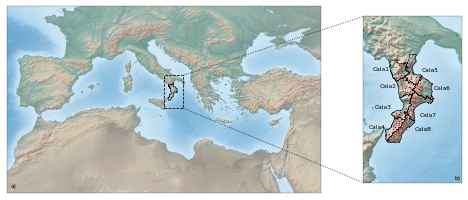

In [15]:
dom_used = 'Calabria'
    
fname2 = 'HYP_HR_SR_OB_DR.tif'
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.PlateCarree()), 
                       gridspec_kw={'width_ratios': [4, 1]}, figsize=(18/2.54, 7/2.54)) 

ax[0].imshow(imread(fname2), origin='upper', extent=[-180, 180, -90, 90])
ax[1].imshow(imread(fname2), origin='upper', extent=[-180, 180, -90, 90])

ax[0].set_extent([-11, 41, 26, 50], crs=ccrs.PlateCarree()) # [-11, 42, 28, 47]
[i_ax.coastlines(resolution='10m', linewidth=.1, color='grey') for i_ax in ax]
domains_used[dom_used][0].iloc[[-1]].boundary.plot(linewidth=.5, edgecolor='black', ax=ax[0])

dom_ext = domains_used[dom_used][1]

rect = plt.Rectangle((dom_ext[0], dom_ext[1]), dom_ext[2]-dom_ext[0], dom_ext[3]-dom_ext[1], 
                     fill=False, color='black', linestyle='--', linewidth=.75) 
ax[0].add_patch(rect) # add rectangle with the actual area used for the Precipitation analysis
ax[0].plot([dom_ext[2], 48], [dom_ext[3], 48.7], color='black', linestyle=':', linewidth=.7, clip_on=False)
ax[0].plot([dom_ext[2], 48], [dom_ext[1], 27.3], color='black', linestyle=':', linewidth=.7, clip_on=False)

polygons_used = domains_used[dom_used][0].iloc[:-1, :]
polygons_used.boundary.plot(linewidth=.5, edgecolor='black', ax=ax[1])
for i_area in range(len(polygons_used)):
    i_name = polygons_used.iloc[[i_area]]['name_area'].tolist()[0]
    i_y = polygons_used.iloc[i_area].geometry.centroid.coords[0][1]
    i_x = polygons_used.iloc[[i_area]].total_bounds
    if '7'==i_name[-1:]:
        i_y = (i_x[1]+i_x[3])/2-(i_x[3]-i_x[1])/3
        i_x = (i_x[0]+i_x[2])/2
    else:
        i_x = i_x[0] if i_name[-1:] in ['1', '2', '3', '4'] else i_x[2]
    i_al = 'right' if i_name[-1:] in ['1', '2', '3', '4'] else 'left'
    ax[1].annotate(text=i_name, size=6,
                   xy=(i_x, i_y),
                   ha=i_al)

eobs_locs = pd.read_csv('Eobs_All.csv')

eobs_locs.columns = [ i.strip() for i in eobs_locs.columns]

eobs_locs.START = pd.to_datetime(eobs_locs.START)
eobs_locs.STOP = pd.to_datetime(eobs_locs.STOP)

stop_min = pd.to_datetime('1979-01-01') # use any station that has data for at least 1 day between 1979-2019
eobs_locs = eobs_locs.query('STOP >= @stop_min')
start_max = pd.to_datetime('2019-12-31') # use any station that has data for at least 1 day between 1979-2019
eobs_locs = eobs_locs.query('START <= @start_max')

sns.scatterplot(data=eobs_locs, x='LON', y='LAT', color='red', linewidth=0, ax=ax[1], s=2) 

ax[1].set_extent([dom_ext[0], dom_ext[2], dom_ext[1], dom_ext[3]], crs=ccrs.PlateCarree())

ax[0].text(x=0.01, y=0.05, s='a)', va='top', transform=ax[0].transAxes, size=6)
ax[1].text(x=0.99, y=0.05, s='b)', va='top', ha='right', transform=ax[1].transAxes, size=6)


plt.subplots_adjust(left=0, bottom=0.03, right=.97, top=.97, wspace=0.005)
fig.savefig(f'{out_dir}{plots_loc}{dom_used}/Fig1_Python.png', dpi=1200, transparent=True)
fig.savefig(f'{out_dir}{plots_loc}{dom_used}/Fig1_Python.pdf', dpi=1200)
    
del(dom_used, fname2, fig, ax, dom_ext, rect, polygons_used, i_area, i_y, i_x, 
    eobs_locs, stop_min, start_max)

Auxiliary to have an understanding about the number of cells that Calabria is represented within ERA5 model.

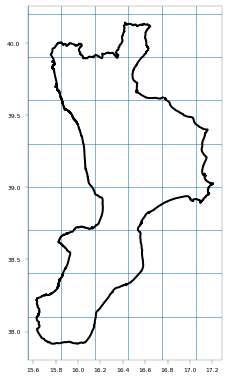

In [16]:
dom_used = 'Calabria'
dom_ext = domains_used['Calabria'][0].iloc[-1:,]
fig, ax = plt.subplots(1, 1, figsize=(4, 6.5))
polygons_used = domains_used[dom_used][0].iloc[-1:, :]
polygons_used.boundary.plot(linewidth=2, edgecolor='black', ax=ax, zorder=10)

user_interval = .3
xmin,xmax = ax.get_xlim()
for _x in np.arange(xmin, xmax, user_interval):
    ax.axvline(x=_x, ls='-')
ymin,ymax = ax.get_ylim()
for _y in np.arange(ymin, ymax, user_interval):
    ax.axhline(y=_y, ls='-')

del(dom_used, dom_ext, fig, ax, polygons_used, user_interval, xmin, xmax, _x, ymin, ymax, _y)

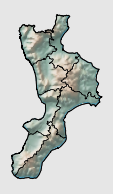

In [17]:
dom_used = 'Calabria'
dom_ext = domains_used['Calabria'][0].iloc[-1:,]
fig, ax = plt.subplots(1, 1, figsize=(3.5/2.54, 6.5/2.54))
fname2 = 'HYP_HR_SR_OB_DR.tif'
clipped_orography = rxr.open_rasterio(fname2).rio.clip(dom_ext.geometry)
# add value for making the external area a color: + 255 for while, +230 for light grey, ...
clipped_orography = (clipped_orography*0+230).where(clipped_orography.sum('band')==0).fillna(0)+\
                     clipped_orography.where(clipped_orography.sum('band')!=0).fillna(0)
ax.imshow((clipped_orography.astype(int).transpose(..., 'band')) , 
          extent=[clipped_orography.x[0], clipped_orography.x[-1], 
                  clipped_orography.y[-1], clipped_orography.y[0]])
polygons_used = domains_used[dom_used][0].iloc[:-1, :]
polygons_used.boundary.plot(linewidth=.5, edgecolor='black', ax=ax, zorder=5)
polygons_used = domains_used[dom_used][0].iloc[-1:, :]
polygons_used.boundary.plot(linewidth=1, edgecolor='black', ax=ax, zorder=10)
ax.axis('off')
fig.patch.set_facecolor([230/255, 230/255, 230/255])
plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
fig.savefig(f'{out_dir}{plots_loc}{dom_used}/GraphAbsAux1.png', dpi=1200)
fig.savefig(f'{out_dir}{plots_loc}{dom_used}/GraphAbsAux1.pdf', dpi=1200)

del(dom_used, dom_ext, fig, ax, fname2, clipped_orography, polygons_used)

In [18]:
def plot_extremes_hits(location_used, percent_used, types_used=list(range(5)), fig_name='Fig5'):
    
    types_used_ordered = np.array(types_used_all)[types_used]
    
    medpat_used_all = results_all[location_used]['MedPatterns']['CondProbs'].sel(percentile=percent_used)
    medpat_used_all = medpat_used_all.sel(Constraints=0, CondProbType='Pos')

    medpat_used = medpat_used_all.sel(wvf_percentile=0, Extra='Alone', wvf_direction='WestW')
    medpat_used = medpat_used['CondProbs'].reset_coords(drop=True)
    best_cluster = medpat_used.sel(bootstrap='Q50').argmax('cluster')
    
    medpat_used = [medpat_used.sel(cluster=i, WarnArea=j).drop('cluster') 
                   for j,i in enumerate(best_cluster.values)]
    
    # reorder best_cluster based on plot order of the warning areas
    best_cluster = best_cluster.assign_coords({'WarnArea': warn_areas_ordered}).sortby('WarnArea').values
    
    medpat_used = xr.concat(medpat_used, dim='WarnArea')
    medpat_used = medpat_used.assign_coords({'predictor': types_used_all[0]})

    wvf_used = results_all[location_used]['WvfERA5']['CondProbs']
    wvf_used = wvf_used.sel(percentile=percent_used, Constraints=0, extr_predictor=1)
    wvf_used = wvf_used.to_array().isel(variable=0).reset_coords(drop=True)
    wvf_best_pred = wvf_used.isel(wvf_direction=wvf_used.wvf_direction!='RH850')
    wvf_best_pred = wvf_best_pred.sel(bootstrap="Q50").idxmax('wvf_direction')
    
    single_wvf = [wvf_used.sel(wvf_direction=j, WarnArea=i, Extra='Alone').drop(['wvf_direction', 'Extra'])
                  for i, j in enumerate(wvf_best_pred.sel(Extra='Alone').values)]
    single_wvf = xr.concat(single_wvf, dim='WarnArea').assign_coords({'predictor': types_used_all[1]})
    single_rh = wvf_used.sel(wvf_direction='RH850', Extra='Alone').reset_coords(drop=True)
    single_rh = single_rh.assign_coords({'predictor': types_used_all[2]})
    rh_wvf = [wvf_used.sel(wvf_direction=j, WarnArea=i, Extra='RH850').drop(['wvf_direction', 'Extra'])
              for i, j in enumerate(wvf_best_pred.sel(Extra='RH850').values)]
    rh_wvf = xr.concat(rh_wvf, dim='WarnArea').assign_coords({'predictor': types_used_all[3]})
    
    # reorder wvf_best_pred based on plot order of the warning areas
    wvf_best_pred = wvf_best_pred.assign_coords({'WarnArea': warn_areas_ordered}).sortby('WarnArea')
    
    
    combo_best_pred = wvf_used.sel(bootstrap="Q50").stack(combo=['Extra', 'wvf_direction']).idxmax('combo')

    local_pred = [wvf_used.sel(wvf_direction=j[1], WarnArea=i, Extra=j[0]).drop(['wvf_direction', 'Extra'])
                  for i, j in enumerate(combo_best_pred.values)]
    local_pred = xr.concat(local_pred, dim='WarnArea').assign_coords({'predictor': types_used_all[5]})
    
    # reorder combo_best_pred based on plot order of the warning areas
    combo_best_pred = combo_best_pred.assign_coords({'WarnArea': warn_areas_ordered}).sortby('WarnArea')
    
    precip_used = results_all[location_used]['PrecipERA5']['CondProbs']
    precip_used = precip_used.sel(percentile=percent_used, Constraints=0, extr_predictor=1)
    precip_used = precip_used.to_array().isel(variable=0).reset_coords(drop=True)
    precip_used = precip_used.expand_dims({'predictor': [types_used_all[4]]})

    predictors_all = [medpat_used, single_wvf, single_rh, rh_wvf, precip_used, local_pred]
    predictors_all = xr.concat(predictors_all, dim='predictor')*100
    predictors_all.name = 'Overlap'
    predictors_all = predictors_all.to_dataframe().reset_index()
    predictors_all.WarnArea = predictors_all.WarnArea.map({i: j for i, j in enumerate(warn_areas_ordered)})
    
    areas_all = len(domains_used[location_used][0])

    fig, ax = plt.subplots(1, 1, figsize=(18/2.54, 7/2.54))
    ax = sns.barplot(data=predictors_all.query('bootstrap=="Q50"'), x='WarnArea', y='Overlap', hue='predictor',
                     hue_order=types_used_ordered, palette=color_palette)
#     h, l = ax.get_legend_handles_labels()

    i_count = 0
    patches = ax.get_children()[:areas_all*len(types_used_ordered)]
    for i_pred in types_used_ordered:
        sub_data = predictors_all.query('predictor==@i_pred and bootstrap in ["Q25", "Q75"]')
        for j in range(areas_all):
            sub_data_j = sub_data.query('WarnArea==@j')
            median = predictors_all.query('predictor==@i_pred and bootstrap=="Q50" and WarnArea==@j')
            median = median['Overlap'].values
            sub_data_j = sub_data_j['Overlap'].values - median
            ax.errorbar(x=patches[i_count].get_x()+patches[i_count].get_width()/2, 
                        y=patches[i_count].get_height(), color='black', linewidth=1,
                        yerr=np.abs(sub_data_j[..., np.newaxis]))
            actual = predictors_all.query('predictor==@i_pred and bootstrap=="Actual" and WarnArea==@j')
            actual = actual['Overlap'].values
            ax.scatter(x=patches[i_count].get_x()+patches[i_count].get_width()/2, 
                       y=actual, marker='_', color='0.7', linewidth=1, zorder=5)
            if i_pred == 'MedPat.':
                text_used = best_cluster[j]
                ax.text(x=patches[i_count].get_x()+patches[i_count].get_width()/2, y=0.5, 
                        s=pat_names_short[text_used], rotation=90, ha='center', va='bottom', 
                        bbox=dict(facecolor='white', edgecolor='white', pad=.1), 
                        color=pat_colors[text_used], size=6)
            if i_pred == 'WVF':
                text_used = wvf_best_pred.sel(Extra='Alone', WarnArea=j).values.tolist()
                ax.scatter(x=patches[i_count].get_x()+patches[i_count].get_width()/2, s=6, zorder=10,
                           y=2, marker=wvf_directions_symbols[text_used], color='white')
            if i_pred == 'WVF + RH850':
                text_used = wvf_best_pred.sel(Extra='RH850', WarnArea=j).values.tolist()
                ax.scatter(x=patches[i_count].get_x()+patches[i_count].get_width()/2, s=6, zorder=10,
                           y=2, marker=wvf_directions_symbols[text_used], color='white')
            if i_pred == 'Local Pred.':
                text_used = combo_best_pred.sel(WarnArea=j).values.tolist()
                ax.scatter(x=patches[i_count].get_x()+patches[i_count].get_width()/2, s=6, zorder=10,
                           y=2, marker=wvf_directions_symbols[text_used[1]], color='white')
                ax.scatter(x=patches[i_count].get_x()+patches[i_count].get_width()/2, s=6, zorder=10,
                           y=4, marker=wvf_directions_symbols[text_used[0]], color='white')

            i_count+=1

    ax.axhline(y=100-percent_used, color='red', linestyle=':', zorder=5)
    ax.set_ylabel('EPEs Hits (%)')
    ax.set_ylim(0, np.ceil(predictors_all.query('bootstrap=="Q50"').Overlap.max()/5)*5)
    ax.set_xlabel('')
    ax.set_xticklabels(['']*areas_all)
    [ax.axvline(i-.5, color='black', linestyle='--') for i in range(1, areas_all)]
    for i, j in enumerate(warn_areas_ordered):
        ax_sub = inset_axes(ax, loc=9, width='80%', height='80%', bbox_to_anchor=(-.5+j, -20, 1, 20),
                            bbox_transform=ax.transData) # create the axes of the bar
        domains_used[location_used][0].boundary.plot(color='black', linewidth=.2, ax=ax_sub)
        domains_used[location_used][0].loc[[i]].plot(alpha=1, color='grey', ax=ax_sub)
        ax_sub.axis('off')

    ax.set_xlim(-.5, areas_all-.5)
    leg = ax.legend(bbox_to_anchor=(1, 1), framealpha=0, title='Predictor')
    leg._legend_box.align = "left"
        
    fig.subplots_adjust(bottom=0.22, right=0.87, left=0.07, top=0.99)
    file_name = f'{out_dir}{plots_loc}{location_used}/{fig_name}'
    fig.savefig(file_name+'.png', dpi=600, transparent=True)
    fig.savefig(file_name+'.pdf', dpi=600)
    if percent_used!=95: plt.close()

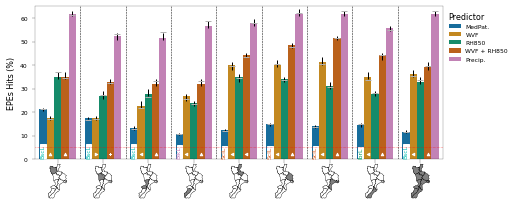

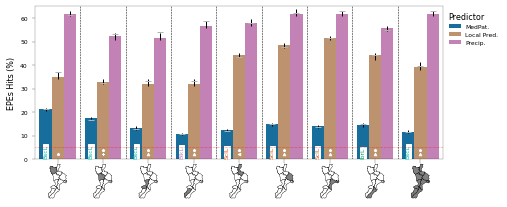

In [19]:
all_combs = list(product(areas_used, perc_used))
for i_comb, i_name in zip(all_combs, [f'FigS{i+3}' for i in range(len(all_combs))]):
    fig = plot_extremes_hits(i_comb[0], i_comb[1], list(range(5)), i_name)
    if i_comb[1]==95: fig = plot_extremes_hits(i_comb[0], i_comb[1], [0, 5, 4], 'Fig5')

del(all_combs, i_comb, i_name, fig)

In [20]:
def cond_prob_patterns(location_used):
    
    condprobs_all = results_all[location_used]['MedPatterns']['CondProbs'].copy(deep=True)
    condprobs_all['CondProbs'] = condprobs_all['CondProbs']/(100-condprobs_all['CondProbs'].percentile)*100

    condprobs = condprobs_all.sel(CondProbType='Pos', wvf_percentile=0, wvf_direction='Total')
    condprobs = condprobs.sel(Extra='Alone', Constraints=0).reset_coords(drop=True)
    condprobs = condprobs.to_dataframe().reset_index()
    condprobs['Aux'] = np.nan
    condprobs['WarnArea_ordered'] = condprobs.WarnArea.map({i: j for i, j in enumerate(warn_areas_ordered)})
    
    
    fig = sns.catplot(data=condprobs.query('bootstrap=="Q50"'), y='Aux', x='cluster', hue='percentile', 
                      col_order=range(len(warn_areas_ordered)),
                      kind='box', col='WarnArea_ordered', col_wrap=3, legend=False, margin_titles=False)

    for i_ind, i_ax in enumerate(warn_areas_ordered):

        plot_median = condprobs.query('bootstrap in ["Q50"] and WarnArea==@i_ind')
        sns.barplot(data=plot_median, y='CondProbs', x='cluster', hue='percentile', zorder=1, dodge=1, 
                    ax=fig.axes.flatten()[i_ax])

        i_count = 0
        patches = fig.axes.flatten()[i_ax].get_children()
        patches = patches[len(perc_used):(len(pat_names)*len(perc_used)+len(perc_used))]
        for j in perc_used:
            sub_data = condprobs.query('percentile==@j and bootstrap in ["Q25", "Q75"] and WarnArea==@i_ind')
            for i_pred in range(len(pat_names)):
                sub_data_j = sub_data.query('cluster==@i_pred and Subset=="All"')
                median = condprobs.query('cluster==@i_pred and bootstrap=="Q50" and percentile==@j')
                median = median.query('WarnArea==@i_ind and Subset=="All"').CondProbs.values
                sub_data_j = sub_data_j['CondProbs'].values - median
                fig.axes.flatten()[i_ax].errorbar(x=patches[i_count].get_x()+patches[i_count].get_width()/2, 
                                                  y=patches[i_count].get_height(), color='black',
                                                  yerr=np.abs(sub_data_j[..., np.newaxis]))
                actual = condprobs.query('percentile==@j and bootstrap=="Actual" and cluster==@i_pred')
                actual = actual.query('WarnArea==@i_ind and Subset=="All"')['CondProbs'].values
                fig.axes.flatten()[i_ax].scatter(x=patches[i_count].get_x()+patches[i_count].get_width()/2,#*3/2,
                                                 y=actual, marker='_', color='0.7', zorder=10)

                i_count+=1

        fig.axes.flatten()[i_ax].axhline(1, linestyle=':', color='red')

        fig.axes.flatten()[i_ax].set_ylim(0, np.ceil(condprobs.CondProbs.max()*10)/10)
        fig.axes.flatten()[i_ax].set_xlabel('')
        fig.axes.flatten()[i_ax].set_ylabel('Cond. Prob. [x nominal prob.]')
        fig.axes.flatten()[i_ax].set_title('')
        fig.axes.flatten()[i_ax].set_xticklabels(pat_names_short, rotation=30)
        fig.axes.flatten()[i_ax].text(x=0.01, y=0.95, s=subplot_id[i_ax]+')', va='bottom', 
                                      transform=fig.axes.flatten()[i_ax].transAxes, size=6)
        
        if i_ind!=len(condprobs.WarnArea.unique())-1:
            ax_sub = inset_axes(fig.axes.flatten()[i_ax], loc=1, width='20%', height='50%')
            domains_used[location_used][0].boundary.plot(color='black', linewidth=.5, ax=ax_sub)
            domains_used[location_used][0].loc[[i_ind]].plot(alpha=.7, color='grey', ax=ax_sub)
            ax_sub.axis('off')

        h, l = fig.axes.flatten()[i_ax].get_legend_handles_labels()
        l = [f'P{i}' for i in l]
        if i_ind!=len(condprobs.WarnArea.unique())-1:
            fig.axes.flatten()[i_ax].get_legend().remove()
        else:
            fig.axes.flatten()[i_ax].legend(h[:len(perc_used)], l[:len(perc_used)], title='EPE Threshold', loc=1)

    fig.fig.set_size_inches(18/2.54, 15/2.54)
    file_name = f'{out_dir}{plots_loc}{location_used}/FigS2'
    fig.savefig(file_name+'.png', dpi=600, transparent=True)
    fig.savefig(file_name+'.pdf', dpi=600)

[None]

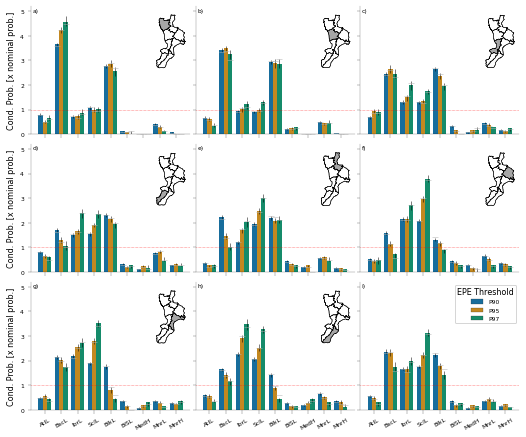

In [21]:
[cond_prob_patterns(i_area) for i_area in areas_used]

In [22]:
def plot_BSS_perfect(ar_used, p_used, file_name_aux):
    
    domain_gdf = domains_used[ar_used][0]

    subregions = [i for i, j in enumerate(domains_used[ar_used][0].name_area.values) if j != 'Full']
    fullregion = [i for i, j in enumerate(domains_used[ar_used][0].name_area.values) if j == 'Full']

    brier_precip = results_all[ar_used]['PrecipERA5']['Brier'].sel(percentile=p_used)
    brier_precip = brier_precip.sel(Constraints=0)
    brier_precip = brier_precip['BSS_clim']
    brier_precip = brier_precip.reset_coords(drop=True).to_dataframe('Values').reset_index()
    brier_precip.columns = ['WarnArea', 'bootstrap', 'BSS_clim']
    brier_precip['Predictor'] = 'Precip'
    brier_precip['Use RH?'] = 'No'

    brier_Med_xr = results_all[ar_used]['MedPatterns']['Brier'].sel(percentile=p_used)
    brier_Med_xr = brier_Med_xr.sel(Constraints=0, Extra='Alone', wvf_percentile=0, wvf_direction='WestW')
    brier_Med_xr = brier_Med_xr['BSS_clim']
    brier_Med_xr = brier_Med_xr.reset_coords(drop=True).to_dataframe().reset_index()
    brier_Med_xr['Predictor'] = 'MedPat.'
    brier_Med_xr['Use RH?'] = 'No'

    brier_WVF_xr = results_all[ar_used]['WvfERA5']['Brier'].sel(percentile=p_used)
    brier_WVF_xr = brier_WVF_xr.sel(Constraints=0)
    brier_WVF_xr = brier_WVF_xr['BSS_clim']
    brier_WVF_xr = brier_WVF_xr.reset_coords(drop=True)
    brier_WVF_xr = brier_WVF_xr.to_dataframe().reset_index()
    brier_WVF_xr.columns = ['Use RH?', 'Predictor', 'WarnArea', 'bootstrap', 'BSS_clim']
    brier_WVF_xr['Use RH?'] = brier_WVF_xr['Use RH?'].map({'Alone': 'No', 'RH850': 'Yes'})

    brier_all = pd.concat([brier_precip, brier_WVF_xr, brier_Med_xr])
    brier_all.rename(columns={'BSS_clim': 'BSS'}, inplace=True)
    brier_all['WarnArea_ordered'] = brier_all.WarnArea.map({i: j for i, j in enumerate(warn_areas_ordered)})
    
    all_pred = len(brier_all.Predictor.unique())

    fig = sns.catplot(data=brier_all.query('bootstrap=="Q50"'), x='Predictor', y='BSS', hue='Use RH?', 
                      col='WarnArea_ordered', col_order=range(len(warn_areas_ordered)),
                      col_wrap=3, kind='bar', legend_out=False)
    
    for i_ind, i_ax in enumerate(warn_areas_ordered):

        patches = fig.axes.flatten()[i_ax].get_children()[:2*all_pred]
        patches[0].set_width(patches[0].get_width()*2)
        patches[all_pred-2].set_width(patches[all_pred-2].get_width()*2)
        patches[all_pred-2+all_pred].set_width(0)
        patches[all_pred-1].set_width(patches[all_pred-1].get_width()*2)
        
        fig.axes.flatten()[i_ax].text(x=0.01, y=0.95, s=subplot_id[i_ax]+')', va='bottom', 
                                      transform=fig.axes.flatten()[i_ax].transAxes, size=6)
        
        i_count = 0
        for j in ['No', 'Yes']:
            sub_data = brier_all.query('`Use RH?`==@j and bootstrap in ["Q25", "Q75"] and WarnArea==@i_ind')
            for i_pred in brier_all.Predictor.unique():
                sub_data_j = sub_data.query('Predictor==@i_pred')
                if len(sub_data_j)>0:
                    median = brier_all.query('`Use RH?`==@j and bootstrap=="Q50" and WarnArea==@i_ind')
                    median = median.query('WarnArea==@i_ind and Predictor==@i_pred').BSS.values
                    sub_data_j = sub_data_j['BSS'].values - median
                    fig.axes.flatten()[i_ax].errorbar(x=patches[i_count].get_x()+patches[i_count].get_width()/2, 
                                                      y=patches[i_count].get_height(), color='black',
                                                      yerr=np.abs(sub_data_j[..., np.newaxis]))
                    actual = brier_all.query('`Use RH?`==@j and bootstrap=="Actual" and WarnArea==@i_ind')
                    actual = actual.query('WarnArea==@i_ind and Predictor==@i_pred').BSS.values
                    fig.axes.flatten()[i_ax].scatter(x=patches[i_count].get_x()+patches[i_count].get_width()/2, 
                                                     y=actual, marker='_', color='0.7', zorder=10)

                i_count+=1

        fig.axes.flatten()[i_ax].axvline(.5, color='black', linestyle='--')
        fig.axes.flatten()[i_ax].axhline(0, color='red', linestyle=':')
        fig.axes.flatten()[i_ax].axvline(all_pred-1.5, color='black', linestyle='--')
        
        h, l = fig.axes.flatten()[i_ax].get_legend_handles_labels()
            
        if i_ax!=len(brier_all.WarnArea.unique())-1:
            ax_sub = inset_axes(fig.axes.flatten()[i_ax], loc=1, width='20%', height='50%')
            ax_sub.set_zorder(100)
            domains_used[ar_used][0].boundary.plot(color='black', linewidth=.5, ax=ax_sub)
            domains_used[ar_used][0].plot(alpha=1, color='white', ax=ax_sub)
            domains_used[ar_used][0].loc[[i_ind]].plot(alpha=.7, color='grey', ax=ax_sub)
            ax_sub.axis('off')

        if i_ax==0:
            fig.axes.flatten()[i_ax].get_legend().remove()        
        elif i_ax==len(brier_all.WarnArea.unique())-1:
            fig.axes.flatten()[i_ax].legend(h, l, title='Add RH850?', loc=1)

        fig.axes.flatten()[i_ax].set_title('')
        fig.axes.flatten()[i_ax].set_xticklabels(labels=brier_all.Predictor.unique(), rotation=30)
    
    fig.fig.set_size_inches(18/2.54, 15/2.54)
    file_name = f'{out_dir}{plots_loc}{ar_used}/{file_name_aux}'
    fig.savefig(file_name+'.png', dpi=600, transparent=True)
    fig.savefig(file_name+'.pdf', dpi=600)
    if p_used!=95: plt.close()

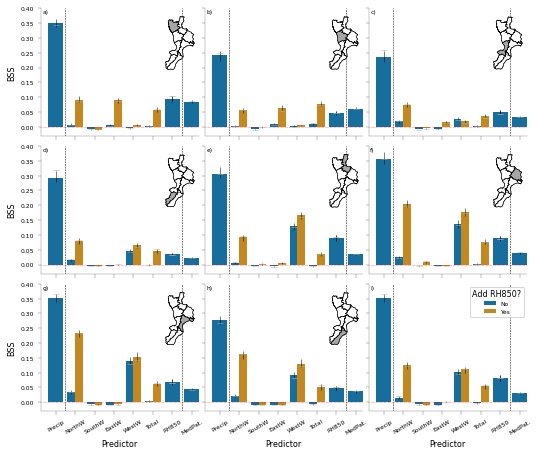

In [23]:
all_combs = list(product(areas_used, perc_used))
for i_comb, i_name in zip(all_combs, ['Aux1', 'Aux2', 'Aux3']):
    fig = plot_BSS_perfect(i_comb[0], i_comb[1], i_name)

del(all_combs, i_comb, i_name, fig)

In [24]:
area_used = 'Calabria'

precip_ERA5 = f'{out_dir}{results_used}{area_used}_PrecipERA5_Timeseries.nc'
precip_ERA5 = xr.open_dataarray(precip_ERA5)
precip_ERA5.name = 'ERA5'

precip_EOBS = f'{out_dir}{results_used}{area_used}_PrecipObs_Timeseries.nc'
precip_EOBS = xr.open_dataarray(precip_EOBS)
precip_EOBS.name = 'Obs'

era5_med = out_dir+'Med_LocalizedPatterns_Labels.nc'
era5_med = xr.open_dataarray(era5_med).sel(rolling=rolling_days, variable_type='Anomalies')
era5_med = era5_med.sel(ClustersNumber='Clusters_9').reset_coords(drop=True)
era5_med.name = 'Patterns'
era5_med = era5_med.sel(time=precip_EOBS.time)

data_all = xr.merge([precip_ERA5, precip_EOBS, era5_med])
data_all_xr = data_all.isel(time=range(0, len(data_all.time), rolling_days))

if 'Winter' in results_used:
    data_all_xr = data_all_xr.isel(time=data_all_xr.time.dt.month.isin([1, 2, 9, 10, 11, 12]))
elif 'Winter' in results_used:
    data_all_xr = data_all_xr.isel(time=data_all_xr.time.dt.month.isin([3, 4, 5, 6, 7, 8]))
    
data_all = data_all_xr.to_dataframe().reset_index()
data_all['Patterns'] = data_all.Patterns.map({i:j for i, j in enumerate(pat_names)})
data_all['Aux'] = -1
data_all['Aux2'] = np.nan
data_all['WarnArea_ordered'] = data_all.WarnArea.map({i: j for i, j in enumerate(warn_areas_ordered)})
    
del(area_used, precip_ERA5, precip_EOBS, data_all_xr)

In [25]:
def fig4_type(area_used, warn_areas_actual, fig_height=18.5, leg_offset=0.05, fig_name='Fig4_full'):
    
    warn_areas_final = np.array([np.where(np.array(warn_areas_ordered)==i) for i in warn_areas_actual]).flatten()
    
    p_intensities = pd.DataFrame({'ERA5': np.nan, 'Obs': np.nan}, index=data_all.WarnArea.unique())
    data_all_final = data_all.query('WarnArea in @warn_areas_final')
    fig = sns.relplot(data=data_all_final, x='ERA5', y='Obs', col='WarnArea_ordered', col_wrap=3,
                      col_order=warn_areas_actual, s=10,
                      hue='Patterns', hue_order=pat_names, alpha=.1,
                      markers={j:i for i, j in zip(markers_symbols, pat_names)}, 
                      palette=pat_colors, style='Patterns', kind='scatter', legend=False)

    for i_ind, i_ax in enumerate(warn_areas_final):

        data_used = data_all.query('WarnArea==@i_ax')
        quantiles = data_used[['ERA5', 'Obs']].quantile(q=.95)
        sns.scatterplot(data=data_used, x='ERA5', y='Obs', hue='Patterns', hue_order=pat_names,
                        palette=pat_colors, style='Patterns', ax=fig.axes.flatten()[i_ind],
                        markers={j:i for i, j in zip(markers_symbols, pat_names)}, s=10, alpha=.3)
        sns.scatterplot(data=data_used.query('ERA5>=@quantiles["ERA5"]'), x='ERA5', y='Obs', hue='Patterns',
                        s=20, hue_order=pat_names, palette=pat_colors, style='Patterns', alpha=.7, 
                        markers={j:i for i, j in zip(markers_symbols, pat_names)}, ax=fig.axes.flatten()[i_ind])
        sns.scatterplot(data=data_used.query('Obs>=@quantiles["Obs"]'), x='ERA5', y='Obs', hue='Patterns',
                        s=40, hue_order=pat_names, palette=pat_colors, style='Patterns', alpha=1, 
                        markers={j:i for i, j in zip(markers_symbols, pat_names)}, ax=fig.axes.flatten()[i_ind])


        fig.axes.flatten()[i_ind].text(x=0.01, y=0.95, s=subplot_id[i_ind]+')', 
                                      va='bottom', transform=fig.axes.flatten()[i_ind].transAxes, size=6)

        fig.axes.flatten()[i_ind].plot([0, 1], [0, 1], transform=fig.axes.flatten()[i_ind].transAxes, 
                                      linestyle='--', color='black')

        ax_sub = inset_axes(fig.axes.flatten()[i_ind], loc=4, width='20%', height='60%')
        domains_used[area_used][0].boundary.plot(color='black', linewidth=.5, ax=ax_sub)
        domains_used[area_used][0].loc[[i_ax]].plot(alpha=.7, ax=ax_sub, color='grey')
        ax_sub.axis('off')

        quantiles = pd.DataFrame(np.round(quantiles, 1))
        p_intensities.iloc[i_ax, :] = quantiles.values.flatten()
        tbl = fig.axes.flatten()[i_ind].table(cellText=quantiles.values,
                                              rowLabels=quantiles.index, colWidths=[.05],
                                              colLabels=['P95'], bbox=[0.12, 0.78, .1, .2])
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(6)
        for key, cell in tbl.get_celld().items():
            cell.set_linewidth(0.1)

        spear = data_all.query('WarnArea==@i_ax')[['ERA5', 'Obs']].corr(method='spearman').values[0, 1]
        pears = data_all.query('WarnArea==@i_ax')[['ERA5', 'Obs']].corr(method='pearson').values[0, 1]
        corr_df = np.round(pd.DataFrame({'Corr': [pears, spear]}, index=['Pearson', 'Spearman']), 2)
        fig.axes.flatten()[i_ind].text(x=.25, y=.9, s=f'Spearman Corr. = {corr_df.loc["Spearman", "Corr"]}', 
                                       size=6, transform=fig.axes.flatten()[i_ind].transAxes)

        fig.axes.flatten()[i_ind].set_title('')
        fig.axes.flatten()[i_ind].set_ylabel('Observations (mm)', size=7)
        fig.axes.flatten()[i_ind].set_xlabel('ERA5 precipitation (mm)', size=7)   

        if i_ind == 0: h, l = fig.axes.flatten()[i_ind].get_legend_handles_labels()
        fig.axes.flatten()[i_ind].get_legend().remove()

    fig.fig.legend(h[:len(pat_names)], l[:len(pat_names)], ncol=len(pat_names), loc=8, 
                   bbox_to_anchor=(.5, -leg_offset))

    # get legend for the size and alpha of the points
    fig.axes.flatten()[i_ind].scatter(x=-10, y=-10, s=10, alpha=.3, color='black', 
                                      label='3-day precipitation events')
    fig.axes.flatten()[i_ind].scatter(x=-10, y=-10, s=20, alpha=.7, color='black', label='ERA5 extremes')
    fig.axes.flatten()[i_ind].scatter(x=-10, y=-10, s=40, alpha=1., color='black', label='E-OBS EPEs')

    fig.axes.flatten()[i_ind].legend()
    h2, l2 = fig.axes.flatten()[i_ind].get_legend_handles_labels()
    fig.axes.flatten()[i_ind].legend().remove()
    fig.fig.legend(h2[-3:], l2[-3:], ncol=3, loc=8, bbox_to_anchor=(.5, -leg_offset-0.03-leg_offset/5))
    for i_ax in fig.axes.flatten():
        i_ax.set_xlim( -5, np.ceil(data_all[['ERA5', 'Obs']].max().max()/10)*10 )
        i_ax.set_ylim( -5, np.ceil(data_all[['ERA5', 'Obs']].max().max()/10)*10 )

    plt.show() # this is needed otherwise the table on the last subplot gets messy (wrong text & cell size)
    fig.fig.set_size_inches(18/2.54, fig_height/2.54)
    file_name = f'{out_dir}{plots_loc}{area_used}/{fig_name}'
    fig.savefig(file_name+'.png', dpi=600, transparent=True)
    fig.savefig(file_name+'.pdf', dpi=600)
    
    if len(warn_areas_actual)==9:
        print('Intensity biases:', 
              np.round(p_intensities.apply(lambda x: (x.ERA5-x.Obs)/x.Obs, axis=1)*100, 2).values)

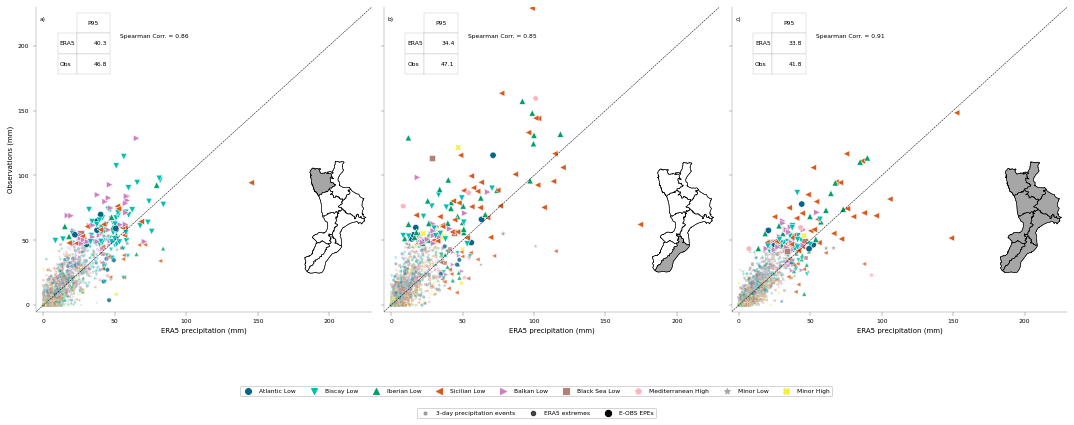

In [26]:
fig4_type('Calabria', [0, 7, 8], fig_height=6.5, leg_offset=0.15, fig_name='Fig4')

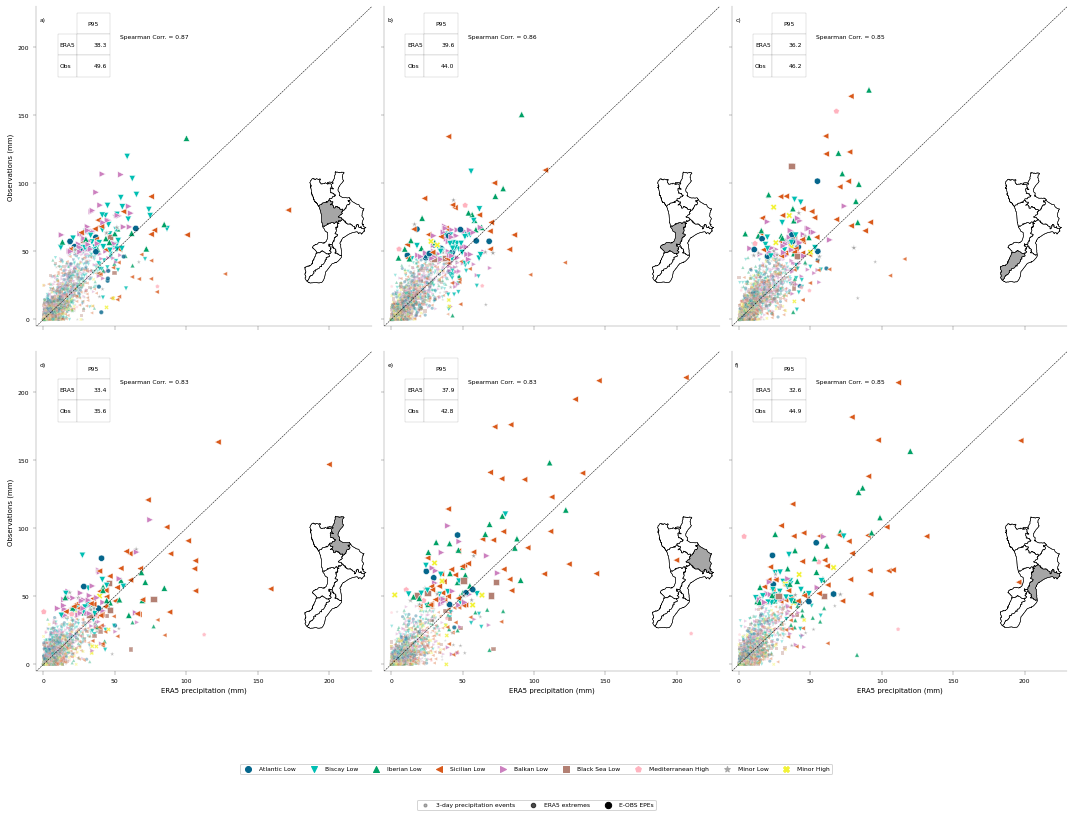

In [27]:
fig4_type('Calabria', range(1, 7), fig_height=12.5, leg_offset=0.1, fig_name='FigS1')

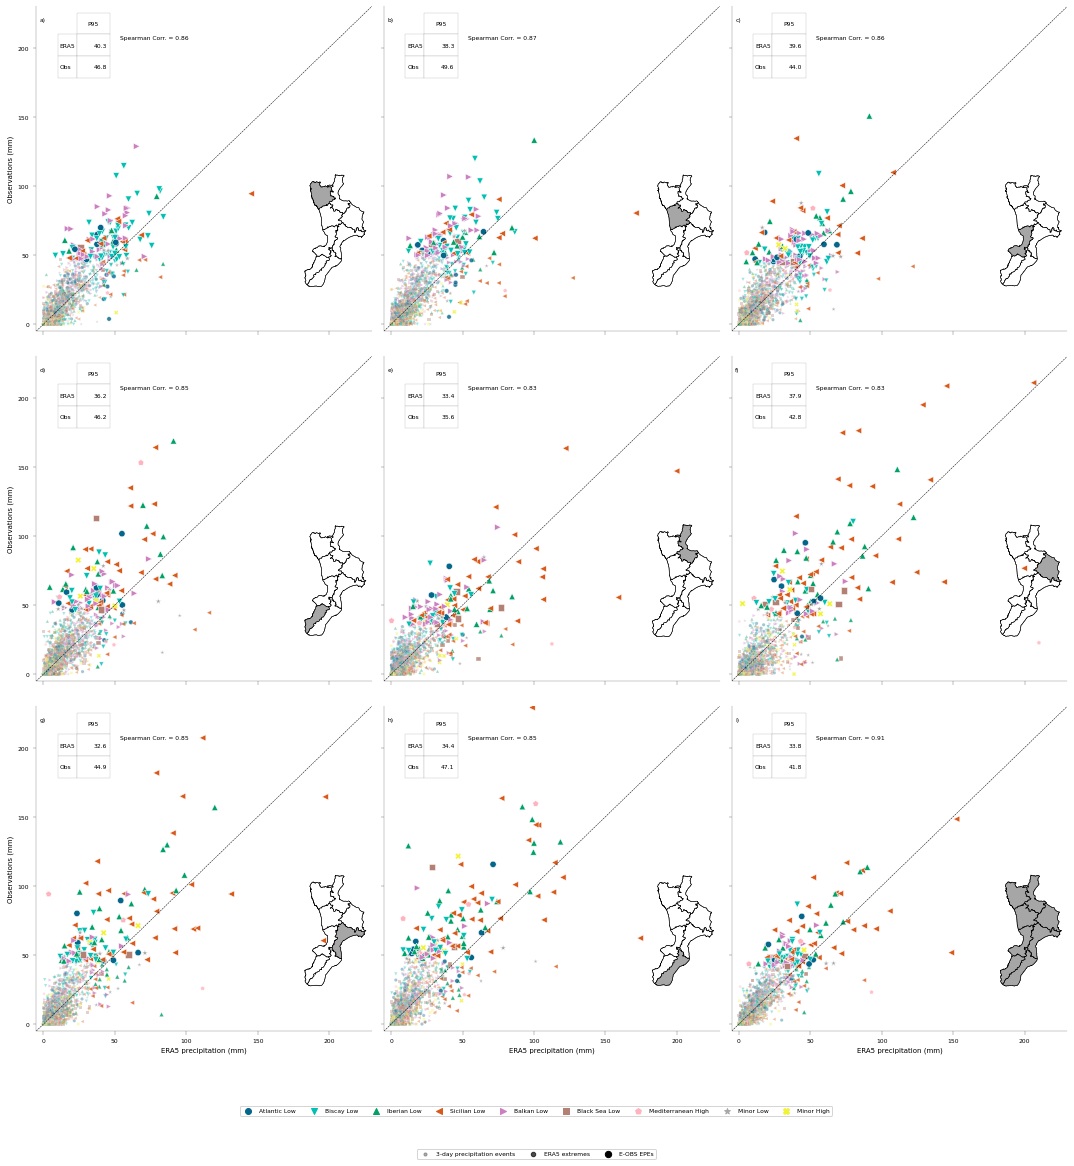

Intensity biases: [ -6.18 -27.39 -22.78 -21.65 -10.   -11.45 -26.96 -13.89 -19.14]


In [28]:
fig4_type('Calabria', range(9), fig_name='Fig4_full')

In [29]:
composites = xr.open_dataset(out_dir+'Med_LocalizedPatterns_Composites.nc').to_array()
composites = composites.sel(variable_type='Anomalies', rolling=rolling_days, ClustersNumber=9)

In [30]:
climfreqs = era5_med
climfreqs = climfreqs.isel(time=range(0, len(climfreqs.time), rolling_days))

if 'Winter' in results_used:
    climfreqs = climfreqs.isel(time=climfreqs.time.dt.month.isin([1, 2, 9, 10, 11, 12]))
elif 'Winter' in results_used:
    climfreqs = climfreqs.isel(time=climfreqs.time.dt.month.isin([3, 4, 5, 6, 7, 8]))

climfreqs = climfreqs.to_dataframe().value_counts(normalize=True).sort_index()*100

In [31]:
title_aux = list(map(chr, range(97, 123)))[:9] # alphabetic order for subplots naming
colors_used = sns.color_palette('RdBu_r', n_colors=15)
colors_used = colors_used[:5]+['white']+colors_used[-5:]
colors_used = ListedColormap(colors_used)
colors_limits = [-14, -11, -8, -5, -3, -.5, .5, 3, 5, 8, 11, 14] # levels for colors (actual abs. max is 13.7)
cont_levels = np.linspace(-21, 21, 13) # act. max is 21.2

x, y = np.meshgrid(composites.longitude, composites.latitude)
max_values = np.abs(composites).max(dim=['cluster', 'latitude', 'longitude']).values
max_values = np.round(max_values/np.array([100, 98.1]), 2)
print('Absolute Max values for SLP and Z500 are {} hPa and {} dam respectively'.\
      format(max_values[0], max_values[1]))

Absolute Max values for SLP and Z500 are 13.61 hPa and 19.02 dam respectively


/var/tmp/tmpdir/monm/jtmp.1998/ipykernel_29673/1933100979.py:11: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(.2) # reduce the border thickness


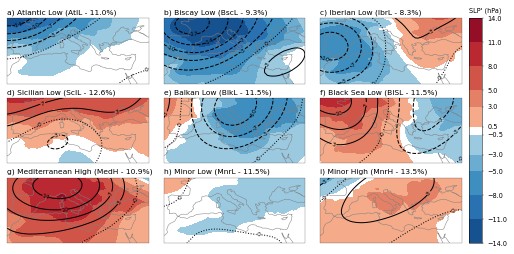

In [32]:
area_used = 'Calabria'
axes_class = (GeoAxes, dict(map_projection=ccrs.PlateCarree()))
fig = plt.figure(figsize=(18/2.54, 9.1/2.54))
grid = AxesGrid(fig, 111, nrows_ncols=(3,3), axes_pad=.2,
                cbar_mode='single', cbar_location='right', cbar_pad=.1,
                axes_class=axes_class, cbar_size='3%', label_mode='')

for i, ax in enumerate(grid):

    ax.set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree()) # set extent
    ax.outline_patch.set_linewidth(.2) # reduce the border thickness
    
    ax.coastlines(resolution='110m', linewidth=.5, color='grey') # add coastline

    contf = ax.contourf(x, y, composites.sel(variable='SLP', cluster=i)/100, # plot contourf for SLP anomalies
                        transform=ccrs.PlateCarree(), levels=colors_limits, cmap=colors_used) 
    cont = ax.contour(x, y, composites.sel(variable='Z500', cluster=i)/98.1, # plot contour for Z500 anomalies
                      transform=ccrs.PlateCarree(),levels=cont_levels, colors='black', linewidths=1) 
    ax.clabel(cont, inline=1, fontsize=6, fmt='%d')
    for line, lvl in zip(cont.collections, cont.levels):
        if lvl == 0:
            line.set_linestyle(':')

    ax.set_title('{}) {} ({} - {:.1f}%)'.format(subplot_id[i], pat_names[i], pat_names_short[i], climfreqs[i]), 
                 pad=4, size=7.5, loc='left',)# backgroundcolor=pat_colors[i])

cbar = ax.cax.colorbar(contf, ticks=colors_limits, spacing='proportional') # add colorbar
cbar.ax.set_title("SLP' (hPa)", size=6.5, loc='left')
cbar.ax.yaxis.set_tick_params(width=.25, length=2, labelsize=6.5)
[i.set_linewidth(0.5) for i in cbar.ax.spines.values()]
    
plt.subplots_adjust(left=0.02, bottom=0.01, right=.95, top=.96)
fig.savefig(f'{out_dir}{plots_loc}{area_used}/Fig2.png', dpi=600, transparent=True)
fig.savefig(f'{out_dir}{plots_loc}{area_used}/Fig2.pdf', dpi=600)

del(area_used, axes_class, fig, grid, i, ax, contf, cont, line, lvl, cbar)

/var/tmp/tmpdir/monm/jtmp.1998/ipykernel_29673/3487082870.py:5: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(.2) # reduce the border thickness


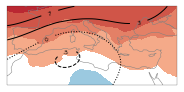

In [33]:
area_used = 'Calabria'
fig, ax = plt.subplots(1, 1, figsize=(6/2.54, 3/2.54), subplot_kw=dict(projection=ccrs.PlateCarree()))
i = 3
ax.set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree()) # set extent
ax.outline_patch.set_linewidth(.2) # reduce the border thickness

ax.coastlines(resolution='110m', linewidth=.5, color='grey') # add coastline

contf = ax.contourf(x, y, composites.sel(variable='SLP', cluster=i)/100, # plot contourf for SLP anomalies
                    transform=ccrs.PlateCarree(), levels=colors_limits, cmap=colors_used) 
cont = ax.contour(x, y, composites.sel(variable='Z500', cluster=i)/98.1, # plot contour for Z500 anomalies
                  transform=ccrs.PlateCarree(),levels=cont_levels, colors='black', linewidths=1) 
ax.clabel(cont, inline=1, fontsize=6, fmt='%d')
for line, lvl in zip(cont.collections, cont.levels):
    if lvl == 0:
        line.set_linestyle(':')
        
plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
fig.savefig(f'{out_dir}{plots_loc}{area_used}/GraphAbsAux2.png', dpi=600, transparent=True)
fig.savefig(f'{out_dir}{plots_loc}{area_used}/GraphAbsAux2.pdf', dpi=600)

del(fig, ax, i, contf, cont, x, y, line, lvl, area_used)

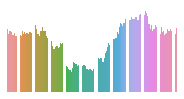

In [34]:
area_used = 'Calabria'
climatological_connections = results_all['Calabria']['ReferenceConnections']['ConnTemp']
climatological_connections = climatological_connections.sel(bootstrap='Q50', percentile=95).isel(WarnArea=-1)
climatological_connections = climatological_connections.to_dataframe().reset_index()
seasons = ["Winter", "Autumn", "Summer", "Spring"]
climatological_connections = climatological_connections.query('temporal not in @seasons')
fig, ax = plt.subplots(1,1, figsize=(6/2.54, 3/2.54))
sns.barplot(data=climatological_connections, x='temporal', y='tp', ax=ax, 
            order=climatological_connections.temporal)
ax.axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
fig.savefig(f'{out_dir}{plots_loc}{area_used}/GraphAbsAux3.png', dpi=600, transparent=True)
fig.savefig(f'{out_dir}{plots_loc}{area_used}/GraphAbsAux3.pdf', dpi=600)

del(area_used, climatological_connections, seasons, fig, ax)

## Predictors' forecasting skill

In [35]:
all_files = !ls $out_dir$results_used
areas_used = sorted(list(set([i.split('_')[0] for i in all_files])))
areas_used_plots = [i for i in areas_used if i != 'Med'] # Med is only used fore reference
del(all_files)

In [36]:
# add np.nan for non-available lead-time, or pointplot shifts data as it is categorical: doesn't know actual locs
def add_zero_lead(xr_data):
    
    steps_needed = xr_data.step.values.min().astype(int)
    
    xr_aux = xr_data.isel(step=range(steps_needed))*np.nan
    xr_aux = xr_aux.assign_coords({'step': range(steps_needed)})
    xr_final = xr.concat([xr_aux, xr_data], dim='step')
    
    return xr_final

In [37]:
med_patterns = out_dir+'Med_LocalizedPatterns_ForecastingBrier.nc'
med_patterns = xr.open_dataset(med_patterns).sel(rolling=rolling_days, variable_type='Anomalies', 
                               ClustersNumber='Clusters_9', Season=season_studied).reset_coords(drop=True)
med_patterns = add_zero_lead(med_patterns)
wvf_data = {i_area: {} for i_area in areas_used_plots}
for i_area in wvf_data:
    file_prefix = out_dir+results_used+i_area+'_WVF_'
    wvf_data[i_area]['Brier'] = xr.open_dataset(file_prefix+'ForecastingBrier.nc')
    wvf_data[i_area]['Brier'] = add_zero_lead(wvf_data[i_area]['Brier'])

precip_data = {i_area: {} for i_area in areas_used_plots}
for i_area in precip_data:
    file_prefix = out_dir+results_used+i_area+'_PrecipERA5_'
    precip_data[i_area]['Brier'] = xr.open_dataset(file_prefix+'ForecastingBrier.nc')
    precip_data[i_area]['Brier'] = add_zero_lead(precip_data[i_area]['Brier'])

del(i_area, file_prefix, areas_used_plots, areas_used)

In [38]:
types_used_order = list(range(5))
types_used_ordered = np.array(types_used_all)[types_used_order]
types_used_ordered

array(['MedPat.', 'WVF', 'RH850', 'WVF + RH850', 'Precip.'], dtype='<U11')

In [39]:
area_used = 'Calabria'

area_xr = wvf_data[area_used]['Brier']
area_xr = area_xr.sel(forecast_type='frcst').to_dataframe().reset_index()
area_xr['wvf_direction'] = area_xr.wvf_direction+[' WVF']+' '+area_xr.Extra
area_xr.rename(columns={'wvf_direction': 'Type'}, inplace=True)

area_xr0 = area_xr.query('Extra=="Alone"').drop(columns='Extra')
area_xr = area_xr.query('Extra!="Alone"').drop(columns='Extra')

area_xr2 = precip_data[area_used]['Brier']
area_xr2 = area_xr2.sel(forecast_type='frcst').to_dataframe().reset_index()
area_xr2['Type'] = 'Precip.'

area_xr3 = med_patterns.expand_dims({'WarnArea': wvf_data[area_used]['Brier'].WarnArea, 
                                     'percentile': wvf_data[area_used]['Brier'].percentile})
area_xr3 = area_xr3.assign_coords({'clim_type': ['Patterns Model Clim', 'Patterns ERA5 Clim']})
area_xr3 = area_xr3.sel(forecast_type='frcst', cluster=-1).drop('cluster')
area_xr3 = area_xr3.rename({'clim_type': 'Type'})
area_xr3 = area_xr3.to_dataframe().reset_index()

area_xr = pd.concat([area_xr0, area_xr, area_xr2, area_xr3])
area_xr.index = range(len(area_xr))
area_xr['BSS_Masked'] = area_xr.BSS.mask(area_xr.BSS_Sign<=.9)
area_xr['BS_Masked'] = area_xr.BS.mask(area_xr.BSS_Sign<=.9)

wvf_dir_used = 'Total'
typ_used = ['Precip.', 'RH850 WVF Alone', f'{wvf_dir_used} WVF Alone', f'{wvf_dir_used} WVF RH850']

del(area_used, area_xr2, area_xr3)

In [40]:
med_df = med_patterns.sel(forecast_type='frcst', bootstrap=['Q5', 'Q50', 'Q95']).to_dataframe().reset_index()
med_df['BSS_Masked'] = med_df.BSS.mask(med_df.BSS_Sign<=.90) # 90% CI for sign on BSS
med_df.cluster = med_df.cluster.astype('str')

In [41]:
used_perc = 95

plot_data_all = area_xr.query('percentile==@used_perc and Type in @typ_used')
plot_data_all = plot_data_all.copy(deep=True)
new_names = {f'{wvf_dir_used} WVF Alone': 'WVF', 'RH850 WVF Alone': 'RH850', 
             f'{wvf_dir_used} WVF RH850': 'WVF + RH850', 'Precip.': 'Precip.'}
plot_data_all.Type.replace(new_names, inplace=True)
typ_used = [new_names[i] for i in typ_used]
plot_data_all.head()

,WarnArea,Type,percentile,bootstrap,step,forecast_type,BS,BSS,BSS_Sign,BSS_Masked,BS_Masked
3312,0,WVF,95,Q5,0,frcst,NaN,NaN,NaN,NaN,NaN
3313,0,WVF,95,Q5,1,frcst,NaN,NaN,NaN,NaN,NaN
3314,0,WVF,95,Q5,2,frcst,0.004354,0.749357,1.0,0.749357,0.004354
3315,0,WVF,95,Q5,3,frcst,0.008249,0.613974,1.0,0.613974,0.008249
3316,0,WVF,95,Q5,4,frcst,0.009027,0.614014,1.0,0.614014,0.009027


In [42]:
def predictors_skill(area_used, ax):
    
    plot_data = plot_data_all.query('WarnArea==@area_used')
    
    sns.pointplot(data=plot_data.query('bootstrap=="Q50"'), 
                  palette=color_palette, markers=markers_symbols, zorder=10,
                  x='step', y='BSS_Masked', hue='Type', hue_order=typ_used, ax=ax)

    sns.lineplot(data=plot_data.query('bootstrap=="Q50"'), palette=color_palette, zorder=5,
                 x='step', y='BSS', hue='Type', linewidth=1, alpha=.3, legend=False, hue_order=typ_used, ax=ax)

    for i_type_ind, i_type in enumerate(typ_used):
        ax.fill_between(plot_data.query('bootstrap=="Q5" and Type==@i_type').step,
                        plot_data.query('bootstrap=="Q5" and Type==@i_type').BSS, 
                        plot_data.query('bootstrap=="Q95" and Type==@i_type').BSS,
                        color=color_palette[i_type], alpha=.1, zorder=0)

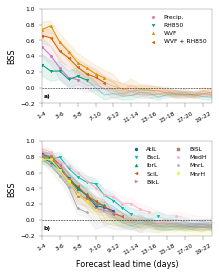

In [43]:
area_used = 'Calabria'

fig, ax = plt.subplots(2, 1, figsize=(8/2.54, 10/2.54))

predictors_skill(max(warn_areas_ordered), ax[0])
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h, l, framealpha=0)
       
# cl_used = 'Model'
cl_used = 'ERA5'

sns.lineplot(data=med_df.query('cluster!="-1" and clim_type==@cl_used and bootstrap=="Q50"'), y='BSS', x='step',
             hue='cluster', style='clim_type', palette=pat_colors, alpha=.3, zorder=1, ax=ax[1])
sns.pointplot(data=med_df.query('cluster!="-1" and clim_type==@cl_used and bootstrap=="Q50"'), y='BSS_Masked', 
              x='step', hue='cluster', linestyles='-', palette=pat_colors, markers=markers_symbols, ax=ax[1])

for i_cl in range(len(pat_names)):
    i_cl_str = str(i_cl)
    range_data = med_df.query('cluster==@i_cl_str and clim_type==@cl_used')
    ax[1].fill_between(range_data.query('bootstrap=="Q5"').step,
                       range_data.query('bootstrap=="Q5"').BSS, 
                       range_data.query('bootstrap=="Q95"').BSS,
                       color=pat_colors[i_cl], alpha=.1, zorder=0)

[i_ax.axhline(0, color='black', linestyle='--') for i_ax in ax]

ax[1].legend().remove()

mark = []
for i in range(len(pat_names)):
    mark_i,  = ax[1].plot([-1, -1.3], [.2, .4], lw=0, marker=markers_symbols[i], color=pat_colors[i], 
                          markersize=3)
    mark.append(mark_i)

ax[1].legend(mark, pat_names_short, ncol=2, framealpha=0)  

[i_ax.set_ylabel('BSS') for i_ax in ax]
ax[0].set_xlabel('')
ax[1].set_xlabel('Forecast lead time (days)')
[i_ax.set_xlim(rolling_days, 22) for i_ax in ax]
[i_ax.set_ylim(np.floor(plot_data_all.BSS.min()*10)/10, 1) for i_ax in ax]
[i_ax.set_xticks(np.arange(rolling_days, 23, 2)) for i_ax in ax]
steps_all = sorted(plot_data_all.step.unique())
tick_names = [str(int(max(i-rolling_days+1, 0)*24))+'-'+str(int((i+1)*24)) for i in steps_all]
tick_names = [str(int(max(i-rolling_days+1, 0)*1))+'-'+str(int((i+1)*1)) for i in steps_all]
ax[1].set_xticklabels(tick_names[rolling_days:23:2], rotation=30)
ax[0].set_xticklabels('')
[i_ax.set_xticklabels(tick_names[rolling_days:23:2], rotation=30) for i_ax in ax]

ax[0].text(x=0.01, y=0.05, s='a)', va='bottom', transform=ax[0].transAxes, size=6, weight='bold')
ax[1].text(x=0.01, y=0.05, s='b)', va='bottom', transform=ax[1].transAxes, size=6, weight='bold')
# ax[0].set_title('a) Precipitation and local predictors', size=7, loc='left')
# ax[1].set_title('b) Mediterranean patterns', size=7, loc='left')


fig.subplots_adjust(bottom=.15, right=0.95, left=0.2, top=.95, hspace=.4)

file_name = f'{out_dir}{plots_loc}{area_used}/Fig6'
fig.savefig(file_name+'.png', dpi=600, transparent=True)
fig.savefig(file_name+'.pdf', dpi=600)

del(area_used, fig, ax, h, l, cl_used, i_cl, i_cl_str, range_data, mark,
    i, mark_i, steps_all, tick_names)

In [44]:
wvf_dir_used = 'Total'
typ_used = ['Precip.', 'RH850 WVF Alone', f'{wvf_dir_used} WVF Alone', 
            f'{wvf_dir_used} WVF RH850']
plot_data_all = area_xr.query('percentile==@used_perc and Type in @typ_used')
plot_data_all = plot_data_all.copy(deep=True)
new_names = {f'{wvf_dir_used} WVF Alone': 'WVF', 'RH850 WVF Alone': 'RH850', 
             f'{wvf_dir_used} WVF RH850': 'WVF + RH850', 'Precip.': 'Precip.'}
plot_data_all.Type.replace(new_names, inplace=True)
typ_used = [new_names[i] for i in typ_used]

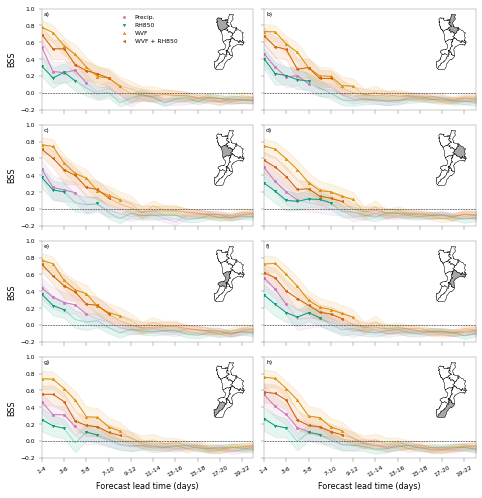

In [45]:
area_used = 'Calabria'
fig, ax = plt.subplots(4, 2, figsize=(18/2.54, 18/2.54))
ax = ax.flatten()

for i_ind, i_area in enumerate([7, 0, 2, 5, 4, 1, 3, 6]):
    
    predictors_skill(i_area, ax[i_ind])
    ax[i_ind].text(x=0.01, y=0.92, s=subplot_id[i_ind]+')', va='bottom', transform=ax[i_ind].transAxes, size=6)

    ax[i_ind].axhline(0, color='black', linestyle='--')
    
    ax_sub = inset_axes(ax[i_ind], loc=1, width='20%', height='60%')
    domains_used['Calabria'][0].boundary.plot(color='black', linewidth=.3, ax=ax_sub)
    domains_used['Calabria'][0].loc[[i_area]].plot(alpha=.7, ax=ax_sub, color='grey')
    ax_sub.axis('off')
    
    if i_ind==0:
        h, l = ax[0].get_legend_handles_labels()
        ax[i_ind].legend(loc=9, framealpha=0)
    else:
        ax[i_ind].get_legend().remove()  
    
    if i_ind in range(0, 8, 2):
        ax[i_ind].set_ylabel('BSS')
    else:
        ax[i_ind].set_ylabel('')
        ax[i_ind].set_yticklabels('')
        
    steps_all = sorted(plot_data_all.step.unique())
    tick_names = [str(int(max(i-rolling_days+1, 0)*24))+'-'+str(int((i+1)*24)) for i in steps_all]
    tick_names = [str(int(max(i-rolling_days+1, 0)*1))+'-'+str(int((i+1)*1)) for i in steps_all]
    
    ax[i_ind].set_xlim(rolling_days, 22)
    ax[i_ind].set_ylim(np.floor(plot_data_all.BSS.min()*10)/10, 1)
    ax[i_ind].set_xticks(np.arange(rolling_days, 23, 2))

    if i_ind in [6, 7]:
        ax[i_ind].set_xlabel('Forecast lead time (days)')
        ax[i_ind].set_xticklabels(tick_names[rolling_days:23:2], rotation=30)
    else:    
        ax[i_ind].set_xlabel('')
        ax[i_ind].set_xticklabels('')
        
fig.subplots_adjust(bottom=.09, right=0.95, left=0.1, top=.97, hspace=.15, wspace=.05)

file_name = f'{out_dir}{plots_loc}{area_used}/FigS6'
fig.savefig(file_name+'.png', dpi=600, transparent=True)
fig.savefig(file_name+'.pdf', dpi=600)

del(area_used, used_perc, wvf_dir_used, typ_used, plot_data_all, new_names, fig, ax, i_ind, i_area, 
    predictors_skill, ax_sub, h, l, steps_all, tick_names,  file_name)

## EPEs forecasting skill

In [46]:
all_files = !ls $out_dir$results_used
areas_used = sorted(list(set([i.split('_')[0] for i in all_files])))
areas_used = [i for i in areas_used if i != 'Med'] # Med is mainly used for reference

In [47]:
types_analysed = ['ReferenceConnections', 'precipERA5', 'precipForecasts', 'wvfERA5', 'MedPatterns']

results_all = {i_area: {i_type: {} for i_type in types_analysed} for i_area in areas_used}
for i_area in areas_used:
    results_all[i_area] = {i_type: {'Brier': [], 'EV': []} for i_type in types_analysed}
    for i_type in types_analysed:
        file_name = f'{out_dir}{results_used}{i_area}_EPEsForecst_{i_type}_Brier.nc'
        results_all[i_area][i_type]['Brier'] = xr.open_dataset(file_name)
        file_name = f'{out_dir}{results_used}{i_area}_EPEsForecst_{i_type}_EV.nc'
        results_all[i_area][i_type]['EV'] = xr.open_dataset(file_name)
    
    file_name = f'{out_dir}{results_used}{i_area}_WvfERA5_Brier.nc'
    results_all[i_area]['wvfERA5']['BrierPerfect'] = xr.open_dataset(file_name)
    file_name = f'{out_dir}{results_used}{i_area}_MedPatterns_Brier.nc'
    results_all[i_area]['MedPatterns']['BrierPerfect'] = xr.open_dataset(file_name)
    
del(all_files, i_area, i_type, file_name)

In [48]:
area_used = 'Calabria'
boot_used = ['Q50', 'Q5', 'Q95']
sign_thrs = .9 # significance used for Brier Skill Score analysis

# brier score of the different combinations of local predictors (wvf, relhum)
wvf_dirs = ['NorthW', 'SouthW', 'EastW', 'WestW', 'Total']

wvf = results_all[area_used]['wvfERA5']['Brier'].sel(bootstrap=boot_used).reset_coords(drop=True)

wvf_brier_perfect = results_all[area_used]['wvfERA5']['BrierPerfect'].sel(bootstrap="Q50", Constraints=0)
wvf_brier_perfect = wvf_brier_perfect.reset_coords(drop=True)

criterion = []
for i_extra in wvf_brier_perfect.Extra.values:
    if i_extra!='Alone': 
        crit_i = wvf_brier_perfect.sel(Extra=i_extra)
    else:
        crit_i = wvf_brier_perfect.sel(wvf_direction=wvf_dirs, Extra=i_extra)
    
    criterion.append( crit_i['BSS_clim_Sign'] == crit_i['BSS_clim_Sign'].max('wvf_direction') )

criterion = xr.concat(criterion, dim='Extra')

wvf_brier_perfect = wvf_brier_perfect['BSS_clim'].where(criterion).idxmax('wvf_direction')

rh_bs_single = wvf.sel(wvf_direction='RH850', Extra='Alone').drop(['wvf_direction', 'Extra'])
rh_bs_single = rh_bs_single.assign_coords({'predictor': 'RH'})

def subset_wvf(extra_dim):
    
    final_ind = wvf_brier_perfect.sel(Extra=extra_dim)
    final_subset = []
    for i_p in final_ind.percentile.values:
        subset_perc = [wvf.sel(wvf_direction=j, WarnArea=i, Extra=extra_dim, percentile=i_p)\
                       .drop(['wvf_direction', 'Extra'])
                       for i, j in enumerate(final_ind.sel(percentile=i_p).values)]

        final_subset.append(xr.concat(subset_perc, dim='WarnArea'))
        
    final_subset = xr.concat(final_subset, dim='percentile')
    return final_subset

wvf_bs_single = subset_wvf('Alone').assign_coords({'predictor': 'WVF'})
wvf_bs_combo = subset_wvf('RH850').assign_coords({'predictor': 'Combo'})

wvf = xr.concat([rh_bs_single, wvf_bs_single, wvf_bs_combo], dim='predictor')

wvf_local = results_all[area_used]['wvfERA5']['Brier'].sel(bootstrap=boot_used).reset_coords(drop=True)
best_local = wvf_local.sel(bootstrap='Q50').stack(combo=['wvf_direction', 'Extra'])
criterion = best_local['BSS_Sign'] == best_local['BSS_Sign'].max('combo')
best_local = best_local.where(criterion)['BSS'].idxmax('combo')

final_subset = []
for i_p in best_local.percentile.values:
    subset_perc = []
    for i_step in best_local.step.values:
        subset_step = [wvf_local.sel(wvf_direction=j[0], WarnArea=i, Extra=j[1], percentile=i_p, step=i_step)\
                       .drop(['wvf_direction', 'Extra'])
                       for i, j in enumerate(best_local.sel(percentile=i_p, step=i_step).values)]

        subset_perc.append(xr.concat(subset_step, dim='WarnArea'))
        
    final_subset.append(xr.concat(subset_perc, dim='step'))

final_subset = xr.concat(final_subset, dim='percentile').assign_coords({'predictor': 'Local Predictors'})

wvf = xr.concat([wvf, final_subset], dim='predictor')

# brier score of bias-corrected precipitation
precip_test = results_all[area_used]['precipERA5']['Brier'].sel(bootstrap=boot_used)
precip_test = precip_test.reset_coords(drop=True).assign_coords({'predictor': 'Precip. Corrected'})

# brier score of actual precipitation
precip_act_test = results_all[area_used]['precipForecasts']['Brier'].sel(bootstrap=boot_used)
precip_act_test = precip_act_test.reset_coords(drop=True).assign_coords({'predictor': 'Precip. Actual'})

# brier score using the Mediterranean patterns
med_test = results_all[area_used]['MedPatterns']['Brier'].sel(bootstrap=boot_used)
med_test_actual = med_test.sel(wvf_percentile=0).isel(wvf_direction=0, Extra=0)
med_test_actual = med_test_actual.reset_coords(drop=True).assign_coords({'predictor': 'MedPat.'})

med_combo = med_test.sel(wvf_percentile=1)
best_combo = med_combo.sel(bootstrap='Q50').stack(combo=['wvf_direction', 'Extra'])
criterion = best_combo['BSS_Sign'] == best_combo['BSS_Sign'].max('combo')
best_local = best_combo.where(criterion)['BSS'].idxmax('combo')

final_subset = []
for i_p in best_local.percentile.values:
    subset_perc = []
    for i_step in best_local.step.values:
        subset_step = [med_combo.sel(wvf_direction=j[0], WarnArea=i, Extra=j[1], percentile=i_p, step=i_step)\
                       .drop(['wvf_direction', 'Extra'])
                       for i, j in enumerate(best_local.sel(percentile=i_p, step=i_step).values)]

        subset_perc.append(xr.concat(subset_step, dim='WarnArea'))
        
    final_subset.append(xr.concat(subset_perc, dim='step'))

final_subset = xr.concat(final_subset, dim='percentile')
final_subset = final_subset.reset_coords(drop=True).assign_coords({'predictor': 'MedPat. combo'})

predictors_bs = xr.concat([wvf, precip_test, precip_act_test, med_test_actual, final_subset], dim='predictor')

steps_int = (predictors_bs.step.values/np.timedelta64(1, 'D')).astype(int)
predictors_bs = predictors_bs.assign_coords({'step': steps_int})
# add np.nan for 0 lead-time, else pointplot shifts data cause it is categorical so does not know actual locs
predictors_bs = add_zero_lead(predictors_bs)

predictors_bs_df = predictors_bs.to_dataframe().reset_index()
# predictors_bs_df.percentile = predictors_bs_df.percentile.astype(str)
predictors_bs_df['BSS_Masked'] = predictors_bs_df.BSS.mask(predictors_bs_df.BSS_Sign<=sign_thrs)
predictors_bs_df['WarnArea_ordered'] = predictors_bs_df.WarnArea.map({i: j 
                                                                     for i, j in enumerate(warn_areas_ordered)})

del(area_used, boot_used, wvf_dirs, wvf, criterion, i_extra, crit_i, wvf_brier_perfect, rh_bs_single, 
    subset_wvf, wvf_bs_single, wvf_bs_combo, wvf_local, best_local, final_subset, i_p, subset_perc, i_step, 
    subset_step, precip_test, precip_act_test, med_test, med_test_actual, med_combo, steps_int)

In [49]:
area_used = 'Calabria'
boot_used = ['Q50', 'Q5', 'Q95']
sign_thrs = .9 # significance used for Brier Skill Score analysis

# brier score of the different combinations of local predictors (wvf, relhum)
wvf_dirs = ['NorthW', 'SouthW', 'EastW', 'WestW', 'Total']

wvf = results_all[area_used]['wvfERA5']['Brier'].sel(bootstrap=boot_used).reset_coords(drop=True)

wvf_brier_perfect = results_all[area_used]['wvfERA5']['BrierPerfect'].sel(bootstrap="Q50", Constraints=0)
wvf_brier_perfect = wvf_brier_perfect.reset_coords(drop=True)

criterion = []
for i_extra in wvf_brier_perfect.Extra.values:
    if i_extra!='Alone': 
        crit_i = wvf_brier_perfect.sel(Extra=i_extra)
    else:
        crit_i = wvf_brier_perfect.sel(wvf_direction=wvf_dirs, Extra=i_extra)
    
    criterion.append( crit_i['BSS_clim_Sign'] == crit_i['BSS_clim_Sign'].max('wvf_direction') )

criterion = xr.concat(criterion, dim='Extra')

wvf_brier_perfect = wvf_brier_perfect['BSS_clim'].where(criterion).idxmax('wvf_direction')

rh_bs_single = wvf.sel(wvf_direction='RH850', Extra='Alone').drop(['wvf_direction', 'Extra'])
rh_bs_single = rh_bs_single.assign_coords({'predictor': 'Indirect - RH'})

def subset_wvf(extra_dim):
    
    final_ind = wvf_brier_perfect.sel(Extra=extra_dim)
    final_subset = []
    for i_p in final_ind.percentile.values:
        subset_perc = [wvf.sel(wvf_direction=j, WarnArea=i, Extra=extra_dim, percentile=i_p)\
                       .drop(['wvf_direction', 'Extra'])
                       for i, j in enumerate(final_ind.sel(percentile=i_p).values)]

        final_subset.append(xr.concat(subset_perc, dim='WarnArea'))
        
    final_subset = xr.concat(final_subset, dim='percentile')
    return final_subset

wvf_bs_single = subset_wvf('Alone').assign_coords({'predictor': 'Indirect - WVF'})
wvf_bs_combo = subset_wvf('RH850').assign_coords({'predictor': 'Indirect - Combo'})

wvf = xr.concat([rh_bs_single, wvf_bs_single, wvf_bs_combo], dim='predictor')

wvf_local = results_all[area_used]['wvfERA5']['Brier'].sel(bootstrap=boot_used).reset_coords(drop=True)
best_local = wvf_local.sel(bootstrap='Q50').stack(combo=['wvf_direction', 'Extra'])
criterion = best_local['BSS_Sign'] == best_local['BSS_Sign'].max('combo')
best_local = best_local.where(criterion)['BSS'].idxmax('combo')

final_subset = []
for i_p in best_local.percentile.values:
    subset_perc = []
    for i_step in best_local.step.values:
        subset_step = [wvf_local.sel(wvf_direction=j[0], WarnArea=i, Extra=j[1], percentile=i_p, step=i_step)\
                       .drop(['wvf_direction', 'Extra'])
                       for i, j in enumerate(best_local.sel(percentile=i_p, step=i_step).values)]

        subset_perc.append(xr.concat(subset_step, dim='WarnArea'))
        
    final_subset.append(xr.concat(subset_perc, dim='step'))

final_subset = xr.concat(final_subset, dim='percentile').assign_coords({'predictor': 'Indirect - Local Pred.'})

wvf = xr.concat([wvf, final_subset], dim='predictor')

# brier score of bias-corrected precipitation
precip_test = results_all[area_used]['precipERA5']['Brier'].sel(bootstrap=boot_used)
precip_test = precip_test.reset_coords(drop=True).assign_coords({'predictor': 'Indirect - Precip.'})

# brier score of actual precipitation
precip_act_test = results_all[area_used]['precipForecasts']['Brier'].sel(bootstrap=boot_used)
precip_act_test = precip_act_test.reset_coords(drop=True).assign_coords({'predictor': 'Direct'})

# brier score using the Mediterranean patterns
med_test = results_all[area_used]['MedPatterns']['Brier'].sel(bootstrap=boot_used)
med_test_actual = med_test.sel(wvf_percentile=0).isel(wvf_direction=0, Extra=0)
med_test_actual = med_test_actual.reset_coords(drop=True).assign_coords({'predictor': 'Indirect - MedPat.'})

med_combo = med_test.sel(wvf_percentile=1)
best_combo = med_combo.sel(bootstrap='Q50').stack(combo=['wvf_direction', 'Extra'])
criterion = best_combo['BSS_Sign'] == best_combo['BSS_Sign'].max('combo')
best_local = best_combo.where(criterion)['BSS'].idxmax('combo')

final_subset = []
for i_p in best_local.percentile.values:
    subset_perc = []
    for i_step in best_local.step.values:
        subset_step = [med_combo.sel(wvf_direction=j[0], WarnArea=i, Extra=j[1], percentile=i_p, step=i_step)\
                       .drop(['wvf_direction', 'Extra'])
                       for i, j in enumerate(best_local.sel(percentile=i_p, step=i_step).values)]

        subset_perc.append(xr.concat(subset_step, dim='WarnArea'))
        
    final_subset.append(xr.concat(subset_perc, dim='step'))

final_subset = xr.concat(final_subset, dim='percentile')
final_subset = final_subset.reset_coords(drop=True).assign_coords({'predictor': 
                                                                   'Indirect - MedPat. & Local Pred.'})

predictors_bs = xr.concat([wvf, precip_test, precip_act_test, med_test_actual, final_subset], dim='predictor')

steps_int = (predictors_bs.step.values/np.timedelta64(1, 'D')).astype(int)
predictors_bs = predictors_bs.assign_coords({'step': steps_int})
# add np.nan for 0 lead-time, else pointplot shifts data cause it is categorical so does not know actual locs
predictors_bs = add_zero_lead(predictors_bs)

predictors_bs_df = predictors_bs.to_dataframe().reset_index()
# predictors_bs_df.percentile = predictors_bs_df.percentile.astype(str)
predictors_bs_df['BSS_Masked'] = predictors_bs_df.BSS.mask(predictors_bs_df.BSS_Sign<=sign_thrs)
predictors_bs_df['WarnArea_ordered'] = predictors_bs_df.WarnArea.map({i: j 
                                                                     for i, j in enumerate(warn_areas_ordered)})
predictors_bs_df.rename(columns={'predictor': 'Method'}, inplace=True)

del(area_used, boot_used, wvf_dirs, wvf, criterion, i_extra, crit_i, wvf_brier_perfect, rh_bs_single, 
    subset_wvf, wvf_bs_single, wvf_bs_combo, wvf_local, best_local, final_subset, i_p, subset_perc, i_step, 
    subset_step, precip_test, precip_act_test, med_test, med_test_actual, med_combo, steps_int)

In [50]:
def brier_EPEs(area_used, used_perc, file_name_aux):
    
    types_used_final = ['Direct', 'Indirect - Precip.', 'Indirect - Local Pred.', 
                        'Indirect - MedPat.', 'Indirect - MedPat. & Local Pred.']
    color_palette = {i: j for i, j in zip(types_used_final, sns.color_palette()[:len(types_used_final)])}    

    markers_used = markers_symbols[:len(types_used_final)]

    data_used = predictors_bs_df.query('percentile==@used_perc and Method in @types_used_final')
    main_data = data_used.query('bootstrap=="Q50"')
    fig = sns.catplot(data=main_data, x='step', y='BSS_Masked', hue='Method', col='WarnArea_ordered', 
                      col_wrap=3, col_order=range(len(warn_areas_ordered)), hue_order=types_used_final,  
                      kind='point', markers=markers_used, margin_titles=True, legend_out=False)

    for i_ind, i_ax in enumerate(warn_areas_ordered):
        sns.lineplot(data=data_used.query('WarnArea==@i_ind and bootstrap=="Q50"'), zorder=5,
                     x='step', y='BSS', hue='Method', linewidth=1, alpha=.35, legend=False, 
                     palette=color_palette, hue_order=types_used_final, ax=fig.axes.flatten()[i_ax])
        range_data = data_used.query('WarnArea==@i_ind and bootstrap!="Q50"')
        for i_type_ind, i_type in enumerate(types_used_final):
            fig.axes.flatten()[i_ax].fill_between(range_data.query('bootstrap=="Q5" and Method==@i_type').step,
                                                  range_data.query('bootstrap=="Q5" and Method==@i_type').BSS, 
                                                  range_data.query('bootstrap=="Q95" and Method==@i_type').BSS,
                                                  color=color_palette[i_type], alpha=.15, zorder=0)

        fig.axes.flatten()[i_ax].axhline(0, linestyle='--', color='black', zorder=-1)
        fig.axes.flatten()[i_ax].set_title('')
        fig.axes.flatten()[i_ax].set_ylabel('BSS')
        fig.axes.flatten()[i_ax].set_ylim(np.floor(data_used.BSS.min()*10)/10, np.ceil(data_used.BSS.max()*10)/10)
        fig.axes.flatten()[i_ax].text(x=0.01, y=0.95, s=subplot_id[i_ax]+')', va='bottom', 
                                      transform=fig.axes.flatten()[i_ax].transAxes, size=6)

        fig.axes.flatten()[i_ax].set_xlabel('Forecast lead time (days)')

        fig.axes.flatten()[i_ax].set_xlim(rolling_days, 19)
        fig.axes.flatten()[i_ax].set_xticks(np.arange(rolling_days, 19, 2))
        steps_all = sorted(data_used.step.unique())
        tick_names = [str(int(max(i-rolling_days+1, 0)*24))+'-'+str(int((i+1)*24)) for i in steps_all]
        tick_names = [str(int(max(i-rolling_days+1, 0)*1))+'-'+str(int((i+1)*1)) for i in steps_all]
        fig.axes.flatten()[i_ax].set_xticklabels(tick_names[rolling_days:19:2], rotation=30)
        
        h, l = fig.axes.flatten()[i_ax].get_legend_handles_labels()
        
        if i_ax==0:
            fig.axes.flatten()[i_ax].get_legend().remove()
        elif i_ax==8:
            fig.axes.flatten()[i_ax].legend(h, l, loc=1)

        if i_ax!=8:
            ax_sub = inset_axes(fig.axes.flatten()[i_ax], loc=1, width='20%', height='60%')
            domains_used[area_used][0].boundary.plot(color='black', linewidth=.5, ax=ax_sub)
            domains_used[area_used][0].loc[[i_ind]].plot(alpha=.7, color='grey', ax=ax_sub)
            ax_sub.axis('off')

    fig.fig.set_size_inches(18/2.54, 15/2.54)
    file_name = f'{out_dir}{plots_loc}{area_used}/{file_name_aux}'
    fig.savefig(file_name+'.png', dpi=600, transparent=True)
    fig.savefig(file_name+'.pdf', dpi=600)
    if used_perc!=95: plt.close()

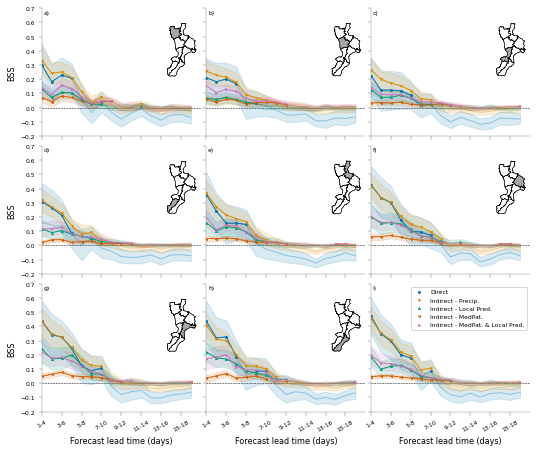

In [51]:
for i_p, i_name in zip(predictors_bs_df.percentile.unique(), ['FigS7', 'Fig7', 'FigS8']):
    brier_EPEs('Calabria', i_p, i_name)
    
del(i_p, i_name)

In [52]:
def reliability_mean(input_data):
    
    out_d = input_data.copy(deep=True)
    
    hitrate_mean = out_d['Hits'].sum('WarnArea')/(out_d['Hits'].sum('WarnArea')+out_d['Misses'].sum('WarnArea'))
    hitrate_mean.name = 'HitRate'
    far_mean = out_d['FalseAlarms'].sum('WarnArea')
    far_mean = far_mean/(out_d['FalseAlarms'].sum('WarnArea')+out_d['CorrectNegative'].sum('WarnArea'))
    far_mean.name = 'FalseAlarmRate'
    
    meanFrcstsMean = out_d['MeanFrcsts'].weighted(out_d['SampleFrcsts']).mean('WarnArea')
    sampleFrcstsTotal = out_d['SampleFrcsts'].sum('WarnArea')
    meanObsMean = out_d['MeanObs'].weighted(out_d['SampleObs']).mean('WarnArea')
    sampleObsTotal = out_d['SampleObs'].sum('WarnArea')
    
    out_d = xr.merge([hitrate_mean, far_mean, meanFrcstsMean, sampleFrcstsTotal, meanObsMean, sampleObsTotal])
    out_d = out_d.assign_coords({'WarnArea': -1})
    
    not_used_keys = set(list(input_data.keys())) - set(list(out_d.keys()))

    for i_key in not_used_keys:
        if i_key not in ['CorrectNegative', 'FalseAlarms', 'Hits', 'Misses']:
            out_d[i_key] = input_data[i_key].mean('WarnArea')
        else:
            out_d[i_key] = input_data[i_key].sum('WarnArea')
    
    out_d = xr.concat([out_d, input_data], dim='WarnArea')
    
    return out_d

In [53]:
test_final = []
wvf_dirs = ['NorthW', 'SouthW', 'EastW', 'WestW', 'Total']

for i_area in areas_used:
    
    wvf_test = results_all[i_area]['wvfERA5']['EV']
    wvf = results_all[i_area]['wvfERA5']['Brier'].sel(bootstrap='Q50').reset_coords(drop=True)

    wvf_brier_perfect = results_all[i_area]['wvfERA5']['BrierPerfect'].sel(bootstrap="Q50", Constraints=0)
    wvf_brier_perfect = wvf_brier_perfect.reset_coords(drop=True)

    criterion = []
    for i_extra in wvf_brier_perfect.Extra.values:
        if i_extra!='Alone': 
            crit_i = wvf_brier_perfect.sel(Extra=i_extra)
        else:
            crit_i = wvf_brier_perfect.sel(wvf_direction=wvf_dirs, Extra=i_extra)

        criterion.append( crit_i['BSS_clim_Sign'] == crit_i['BSS_clim_Sign'].max('wvf_direction') )

    criterion = xr.concat(criterion, dim='Extra')

    wvf_brier_perfect = wvf_brier_perfect['BSS_clim'].where(criterion).idxmax('wvf_direction')

    rh_ev_single = wvf_test.sel(wvf_direction='RH850', Extra='Alone').drop(['wvf_direction', 'Extra'])
    rh_ev_single = rh_ev_single.assign_coords({'Predictor': 'Indirect - RH'})
    
    def subset_wvf(extra_dim):

        final_ind = wvf_brier_perfect.sel(Extra=extra_dim)
        final_subset = []
        for i_p in final_ind.percentile.values:
            subset_perc = [wvf_test.sel(wvf_direction=j, WarnArea=i, Extra=extra_dim, percentile=i_p)\
                           .drop(['wvf_direction', 'Extra'])
                           for i, j in enumerate(final_ind.sel(percentile=i_p).values)]

            final_subset.append(xr.concat(subset_perc, dim='WarnArea'))

        final_subset = xr.concat(final_subset, dim='percentile')
        return final_subset

    wvf_ev_single = subset_wvf('Alone').assign_coords({'Predictor': 'Indirect - WVF'})
    wvf_ev_combo = subset_wvf('RH850').assign_coords({'Predictor': 'Indirect - Combo'})

    wvf = xr.concat([rh_ev_single, wvf_ev_single, wvf_ev_combo], dim='Predictor')

    wvf_local = results_all[i_area]['wvfERA5']['Brier'].sel(bootstrap='Q50').reset_coords(drop=True)
    best_local = wvf_local.stack(combo=['wvf_direction', 'Extra'])
    criterion = best_local['BSS_Sign'] == best_local['BSS_Sign'].max('combo')
    best_local = best_local.where(criterion)['BSS'].idxmax('combo')

    final_subset = []
    for i_p in best_local.percentile.values:
        subset_perc = []
        for i_step in best_local.step.values:
            subset_step = [wvf_test.sel(wvf_direction=j[0], WarnArea=i, Extra=j[1], 
                                        percentile=i_p, step=i_step).drop(['wvf_direction', 'Extra'])
                           for i, j in enumerate(best_local.sel(percentile=i_p, step=i_step).values)]

            subset_perc.append(xr.concat(subset_step, dim='WarnArea'))

        final_subset.append(xr.concat(subset_perc, dim='step'))

    final_subset = xr.concat(final_subset, dim='percentile').assign_coords({'Predictor': 
                                                                            'Indirect - Local Pred.'})

    wvf_test = xr.concat([wvf, final_subset], dim='Predictor')
    wvf_test = reliability_mean(wvf_test).isel(cost_ratio=0).reset_coords(drop=True)
    
    precip_test = results_all[i_area]['precipERA5']['EV']
    precip_test = reliability_mean(precip_test).isel(cost_ratio=0).reset_coords(drop=True)
    precip_test = precip_test.assign_coords({'Predictor': 'Indirect - Precip.'})
    
    precip_act_test = results_all[i_area]['precipForecasts']['EV']
    precip_act_test = reliability_mean(precip_act_test).isel(cost_ratio=0).reset_coords(drop=True)
    precip_act_test = precip_act_test.assign_coords({'Predictor': 'Direct'})
    
    med_test = results_all[i_area]['MedPatterns']['EV']
    med_test_actual = med_test.isel(wvf_percentile=0, Extra=0, wvf_direction=0)
    med_test_actual = med_test_actual.reset_coords(drop='wvf_direction')
    med_test_actual = reliability_mean(med_test_actual).isel(cost_ratio=0).reset_coords(drop=True)
    med_test_actual = med_test_actual.assign_coords({'Predictor': 'Indirect - MedPat.'})
    
    med_combo = med_test.sel(wvf_percentile=1)
    best_combo = results_all[i_area]['MedPatterns']['Brier'].sel(wvf_percentile=1)
    best_combo = best_combo.sel(bootstrap='Q50').stack(combo=['wvf_direction', 'Extra'])
    criterion = best_combo['BSS_Sign'] == best_combo['BSS_Sign'].max('combo')
    best_local = best_combo.where(criterion)['BSS'].idxmax('combo')

    final_subset = []
    for i_p in best_local.percentile.values:
        subset_perc = []
        for i_step in best_local.step.values:
            subset_step = [med_combo.sel(wvf_direction=j[0], WarnArea=i, Extra=j[1], 
                                         percentile=i_p, step=i_step).drop(['wvf_direction', 'Extra'])
                           for i, j in enumerate(best_local.sel(percentile=i_p, step=i_step).values)]

            subset_perc.append(xr.concat(subset_step, dim='WarnArea'))

        final_subset.append(xr.concat(subset_perc, dim='step'))

    final_subset = xr.concat(final_subset, dim='percentile')
    final_subset = reliability_mean(final_subset).isel(cost_ratio=0).reset_coords(drop=True)
    final_subset = final_subset.reset_coords(drop=True).assign_coords({'Predictor': 
                                                                       'Indirect - MedPat. & Local Pred.'})
    
    test_all = [wvf_test, precip_test, precip_act_test, med_test_actual, final_subset]
    test_all = xr.concat(test_all, dim='Predictor')
    test_all = test_all.assign_coords({'Location': i_area})
    test_final.append(test_all)
    
test_final = xr.concat(test_final, dim='Location')
test_final = test_final.assign_coords({'step': test_final.step/np.timedelta64(1, 'D')})
test_final = add_zero_lead(test_final)

reliability_df = test_final.to_dataframe().reset_index()
reliability_df['Sample Size'] = pd.cut(reliability_df.SampleFrcsts, [0, 20, 100, 1000, 10000])
reliability_df.index = range(len(reliability_df))
reliability_df['Aux'] = np.nan
reliability_df.rename(columns={'Predictor': 'Method'}, inplace=True)

del(i_area, wvf_dirs, wvf_test, wvf, wvf_brier_perfect, criterion, i_extra, crit_i, rh_ev_single, subset_wvf,
    wvf_ev_single, wvf_ev_combo, wvf_local, best_local, final_subset, subset_perc, i_p, i_step, subset_step, 
    precip_test, precip_act_test, med_test, med_test_actual, med_combo, test_all, test_final)

In [54]:
def reliability_plot(loc_used, boot_used, used_perc, steps_used, file_name_aux):
    
    if len(steps_used)==3:
        col_wrap = 1
        aux_name = 'Subset'
    else:
        col_wrap = 4
        aux_name = 'Full'

    types_used_final = ['Direct', 'Indirect - Precip.', 'Indirect - Local Pred.', 
                        'Indirect - MedPat.', 'Indirect - MedPat. & Local Pred.']
    color_palette = {i: j for i, j in zip(types_used_final, sns.color_palette()[:len(types_used_final)])}    

    all_types = reliability_df.Method.unique()
    all_types = [i for i in types_used_final if i in all_types]

    data_used = reliability_df.query('percentile==@used_perc and WarnArea==-1 and step in @steps_used')
    data_used = data_used.query('Location==@loc_used and bootstrap==@boot_used and Method in @all_types')
    all_steps = sorted(data_used.step.unique())

    fig = sns.catplot(data=data_used, x='p_thr', y='Aux', alpha=0., col_wrap=col_wrap, palette=color_palette,
                      hue='Method', hue_order=all_types, col='step', kind='point',
                      margin_titles=True, legend=False)

    i_count = 0
    for i_step, ax in zip(all_steps, fig.axes.flatten()):
        subset_used_all = data_used.query('step==@i_step')
        sns.lineplot(data=subset_used_all, x='MeanFrcsts', y='MeanObs', linewidth=3,
                     palette=color_palette, alpha=.7,
                     hue='Method', hue_order=all_types, ax=ax, zorder=5, legend=False)
        sns.scatterplot(data=subset_used_all, x='MeanFrcsts', y='MeanObs', hue='Method', 
                        size='Sample Size', sizes=(50, 5), hue_order=all_types,  style='Method', 
                        palette=color_palette, markers={j:i for i, j in zip(markers_symbols, all_types)},
                        ax=ax, zorder=20, alpha=0.7, legend=True)

        if i_count>0: 
            ax.get_legend().remove() 
        else: 
            h, l = ax.get_legend_handles_labels()
            ax.get_legend().remove()
        
        if (len(steps_used)==3) & (i_count==2):
            legend1 = ax.legend(h[len(all_types):-5], l[len(all_types):-5], loc=1)
            ax.legend(h[-5:], l[-5:], loc=4)
            ax.add_artist(legend1)
        
        else:
            if i_count==12: ax.legend(h[len(all_types):-5], l[len(all_types):-5], loc=1)
            if i_count==13: ax.legend(h[-5:], l[-5:], loc=1)
        
        ax.fill_between(np.array([0, (1-used_perc/100)]), np.array([0, (1-used_perc/100)]),
                        np.array([(1-used_perc/100)/2, (1-used_perc/100)]), color='grey', alpha=.15, zorder=5)
        ax.fill_between(np.array([0, (1-used_perc/100)]), np.array([0, 0]),
                        np.array([0, (1-used_perc/100)]), color='grey', alpha=.15, zorder=5)
        ax.fill_between(np.array([(1-used_perc/100), 1]), np.array([(1-used_perc/100), 1]),
                        np.array([1, 1]), color='grey', alpha=.15, zorder=5)
        ax.fill_between(np.array([(1-used_perc/100), 1]), 
                        np.array([(1-used_perc/100), 1-(1+(1-used_perc/100))/2]),
                        np.array([(1-used_perc/100), 1]), color='grey', alpha=.15, zorder=5)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle='--', alpha=.5, zorder=7)

        ax.axhline(1-used_perc/100, color='black', linestyle='--', alpha=.5, zorder=7)
        max_value = max(subset_used_all.MeanFrcsts.max(), subset_used_all.MeanObs.max())
        max_value = np.ceil(max_value*10)/10
        max_value = 1
        ax.set_xlim(0, max_value)
        ax.set_ylim(0, max_value)
        ax.set_xticks(ax.get_yticks())
        ax.set_xticklabels(np.round(ax.get_yticks(), 2))
        ax.set_ylabel('Relative Frequency')
        ax.set_xlabel('Mean Predicted Value')
        if len(steps_used)==3:
            i_title = f'{subplot_id[i_count]}) Forecast lead time: {int(max(0, i_step-2))}-{int(i_step+1)} days'
        else:
            i_title = f'{subplot_id[i_count]}) Frcst lead days: {int(max(0, i_step-2))}-{int(i_step+1)}'
        
        ax.set_title('')
        ax.set_title(i_title, loc='left', size=7)
        i_count += 1

    fig.fig.subplots_adjust(wspace=.20, hspace=.20, right=0.95, left=.15, top=.95, bottom=.06)  
    if len(steps_used)==3:
        fig.fig.set_size_inches(8/2.54, 14/2.54)
    else:
        fig.fig.set_size_inches(18/2.54, 20/2.54)

    fig_name = f'{out_dir}{plots_loc}{loc_used}/{file_name_aux}'
    fig.fig.savefig(fig_name+'.png', dpi=600)
    fig.fig.savefig(fig_name+'.pdf', dpi=600)
    if used_perc!=95: plt.close()

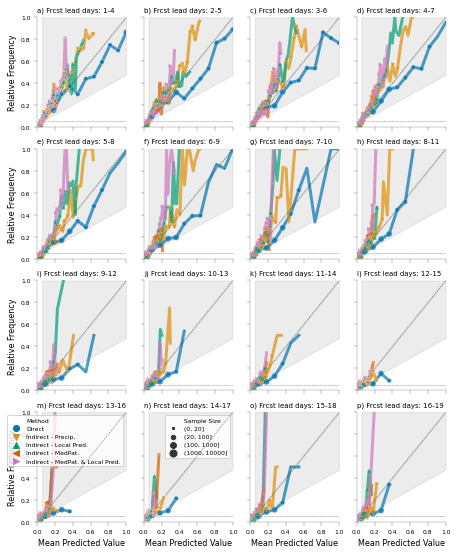

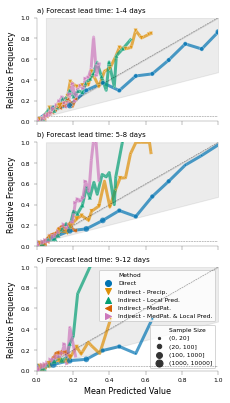

In [55]:
for i_p, i_name in zip(perc_used, ['Aux4', 'Aux5', 'Aux6']):
    reliability_plot('Calabria', 'Q50', i_p, range(rolling_days, 19), i_name)
    if i_p==95: reliability_plot('Calabria', 'Q50', i_p, [3, 7, 11], 'FigA1')
        
del(i_p, i_name)

In [56]:
def res_rel(loc_used, boot_used, used_perc, fig_name_aux):
    
    steps_used = range(rolling_days, 19)
    
    types_used_final = ['Direct', 'Indirect - Precip.', 'Indirect - Local Pred.', 
                        'Indirect - MedPat.', 'Indirect - MedPat. & Local Pred.']
    color_palette = {i: j for i, j in zip(types_used_final, sns.color_palette()[:len(types_used_final)])}    

    all_types = reliability_df.Method.unique()
    all_types = [i for i in types_used_final if i in all_types]

#     data_used = reliability_df.query('percentile==@used_perc and WarnArea==-1 and step in @steps_used')
    data_used = reliability_df.query('percentile==@used_perc and WarnArea!=-1 and step in @steps_used')
    data_used = data_used.query('Location==@loc_used and bootstrap==@boot_used and Method in @all_types')
    all_steps = sorted(data_used.step.unique())

    grouped_cols = ['percentile', 'step', 'bootstrap', 'Method', 'Location', 'WarnArea']
    cols_with_results = ['Uncertainty_Total', 'Resolution_Total', 'Reliability_Total']
    bss_decomposition = data_used.groupby(grouped_cols)[cols_with_results].mean().reset_index()

    bss_decomposition_max = data_used.groupby(grouped_cols[:-1])[cols_with_results].max().reset_index()
    bss_decomposition_min = data_used.groupby(grouped_cols[:-1])[cols_with_results].min().reset_index()
    bss_decomposition_median = data_used.groupby(grouped_cols[:-1])[cols_with_results].median().reset_index()
    
    fig, ax = plt.subplots(2, 1, figsize=(8/2.54, 11/2.54))
#     sns.lineplot(data=bss_decomposition, x='step', y='Resolution_Total', hue='Method', ax=ax[0],
#                  hue_order=all_types,  style='Method',
#                  palette=color_palette, markers={j:i for i, j in zip(markers_symbols, all_types)})
#     sns.lineplot(data=bss_decomposition, x='step', y='Reliability_Total', hue='Method', ax=ax[1],
#                  hue_order=all_types,  style='Method', 
#                  palette=color_palette, markers={j:i for i, j in zip(markers_symbols, all_types)})

    sns.lineplot(data=bss_decomposition_median, x='step', y='Resolution_Total', hue='Method', ax=ax[0],
                 hue_order=all_types,  style='Method', linewidth=2,
                 palette=color_palette, markers={j:i for i, j in zip(markers_symbols, all_types)})
    sns.lineplot(data=bss_decomposition_median, x='step', y='Reliability_Total', hue='Method', ax=ax[1],
                 hue_order=all_types,  style='Method', linewidth=2,
                 palette=color_palette, markers={j:i for i, j in zip(markers_symbols, all_types)})
    for i_type_ind, i_type in enumerate(types_used_final):
        ax[0].fill_between(bss_decomposition_min.query('Method==@i_type').step,
                           bss_decomposition_min.query('Method==@i_type').Resolution_Total, 
                           bss_decomposition_max.query('Method==@i_type').Resolution_Total, 
                           color=color_palette[i_type], alpha=.07, zorder=0)
        ax[1].fill_between(bss_decomposition_min.query('Method==@i_type').step,
                           bss_decomposition_min.query('Method==@i_type').Reliability_Total, 
                           bss_decomposition_max.query('Method==@i_type').Reliability_Total, 
                           color=color_palette[i_type], alpha=.07, zorder=0)

    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles=handles, labels=labels)
    ax[1].legend().remove()
    ax[0].set_ylabel('Resolution')
    ax[1].set_ylabel('Reliability')
    ax[0].set_xlabel('')
    ax[0].set_xticklabels([])
    steps_all = sorted(data_used.step.unique())
    tick_names = [str(int(max(i-rolling_days+1, 0)*24))+'-'+str(int((i+1)*24)) for i in steps_all]
    tick_names = [str(int(max(i-rolling_days+1, 0)*1))+'-'+str(int((i+1)*1)) for i in steps_all]
    ax[1].set_xlabel('Forecast lead time (days)')
    [i_ax.set_xlim(rolling_days, 18) for i_ax in ax]
    [i_ax.set_xticks(np.arange(rolling_days, 19, 2)) for i_ax in ax]
    ax[1].set_xticklabels(tick_names[0:19:2], rotation=30)
    
    ax[0].text(x=0.01, y=0.97, s='a)', va='top', ha='left', transform=ax[0].transAxes, size=6, weight='bold')
    ax[1].text(x=0.01, y=0.97, s='b)', va='top', ha='left', transform=ax[1].transAxes, size=6, weight='bold')

#     ax[0].set_title('a) Resolution', loc='left', size=7)
#     ax[1].set_title('b) Reliability', loc='left', size=7)
    
    fig.subplots_adjust(hspace=.05, right=0.95, left=.2, top=.98, bottom=.15)  
    
    fig_name = f'{out_dir}{plots_loc}{loc_used}/{fig_name_aux}'
    fig.savefig(fig_name+'.png', dpi=600)
    fig.savefig(fig_name+'.pdf', dpi=600)
    if used_perc!=95: plt.close()

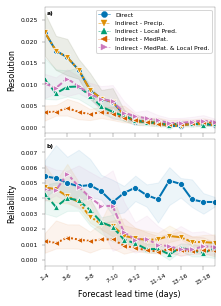

In [57]:
for i_p, i_name in zip(perc_used, ['FigS9', 'Fig8', 'FigS10']):
    res_rel('Calabria', 'Q50', i_p, i_name)
    
del(i_p, i_name)

In [58]:
def roc_plot(loc_used, used_perc, steps_used, fig_name_aux):
    
    shapes_markers = ['●', '▼', '▲', '◄', '►']
    
    if len(steps_used)==4:
        col_wrap = 2
        aux_name = 'Subset'
    else:
        col_wrap = 4
        aux_name = 'Full'

    types_used_final = ['Direct', 'Indirect - Precip.', 'Indirect - Local Pred.', 
                        'Indirect - MedPat.', 'Indirect - MedPat. & Local Pred.']
    color_palette = {i: j for i, j in zip(types_used_final, sns.color_palette()[:len(types_used_final)])}    

    all_types = reliability_df.Method.unique()
    all_types = [i for i in types_used_final if i in all_types]

    data_used = reliability_df.query('percentile==@used_perc and WarnArea==-1 and step in @steps_used')
    data_used = data_used.query('Location==@loc_used and bootstrap=="Q50" and Method in @all_types')
    all_steps = sorted(data_used.step.unique())

    fig = sns.catplot(data=data_used, x='MeanFrcsts', y='Aux', alpha=0., col_wrap=col_wrap, 
                      hue='Method', hue_order=all_types, col='step', kind='point', palette=color_palette,
                      margin_titles=True, legend=False)
        
    i_count = 0
    for i_step, ax in zip(all_steps, fig.axes.flatten()):
        subset_used_all = data_used.query('step==@i_step')
        sns.lineplot(data=subset_used_all, x='FalseAlarmRate', y='HitRate', alpha=0.4, linewidth=3,
                     palette=color_palette, hue='Method', hue_order=all_types, ax=ax, zorder=10, legend=False)
        sns.scatterplot(data=subset_used_all, x='FalseAlarmRate', y='HitRate', hue='Method', 
                        size='Sample Size', sizes=(50, 5), hue_order=all_types,  style='Method', 
                        palette=color_palette,  markers={j:i for i, j in zip(markers_symbols, all_types)},
                        ax=ax, zorder=20, alpha=0.7, legend=True)
        
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle='--', alpha=.5, zorder=7)
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks(ax.get_yticks())
        ax.set_xticklabels(np.round(ax.get_yticks(), 2))
        ax.set_ylabel('Hit Rate')
        ax.set_xlabel('False Alarm Rate')
        i_title = f'{subplot_id[i_count]}) Forecast lead days: {int(max(0, i_step-2))}-{int(i_step+1)}'
        ax.set_title('')
        ax.set_title(i_title, loc='left', size=7)
        
        rocs = pd.DataFrame({'AUCSS': np.nan}, index=all_types)
        for i_type in all_types:
            subset_used_all_type = subset_used_all.query('Method==@i_type')
            subset_used_all_type = subset_used_all_type.sort_values('FalseAlarmRate').query('FalseAlarmRate>=0')
            rocs_i = 2*np.trapz(subset_used_all_type.HitRate, x=subset_used_all_type.FalseAlarmRate)-1
            rocs.loc[i_type, 'AUCSS'] = str("%.3f" % np.round(rocs_i, 3))
        
        tbl = ax.table(cellText=rocs.values, rowColours=sns.color_palette()[:len(all_types)],
#                        rowLabels = shapes_markers[:len(all_types)],
                       rowLabels = rocs.index, colColours=['black'],
                       cellColours=np.array(sns.color_palette()[:len(all_types)])[:, np.newaxis], 
                       colLabels=rocs.columns, colWidths=[.01], loc=4) # colWidths=[.1], 
        # iterate through cells of a table
        table_props = tbl.properties()
        table_cells = table_props['children']
        for i_cell in table_cells: 
                i_cell.get_text().set_fontsize(5.5)
                i_cell.get_text().set_color('white')
        tbl.auto_set_column_width(col=list(range(len(rocs.columns))))
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(6.5)
        tbl.scale(1, 1.5) # for changing cells' height
        
        height = tbl.get_celld()[0,0].get_height()
        for i_sh in range(len(all_types)):
            cell = tbl.add_cell(i_sh+1, -2, width=0.07, height=height, text=shapes_markers[i_sh], loc="center")
            cell.get_text().set_color(sns.color_palette()[i_sh])

        if i_count>0: 
            ax.get_legend().remove() 
        else: 
            h, l = ax.get_legend_handles_labels()
        if i_count==0:
            legend = ax.legend(h[-5:], l[-5:], loc=7)
            
        i_count += 1

    fig.fig.subplots_adjust(wspace=.15, hspace=.15, right=0.95, left=.1, top=.95, bottom=.06)  
    fig.fig.set_size_inches(18/2.54, 15/2.54)

    fig_name = f'{out_dir}{plots_loc}{loc_used}/{fig_name_aux}'
    fig.fig.savefig(fig_name+'.png', dpi=600)
    fig.fig.savefig(fig_name+'.pdf', dpi=600)
    if used_perc!=95: plt.close()

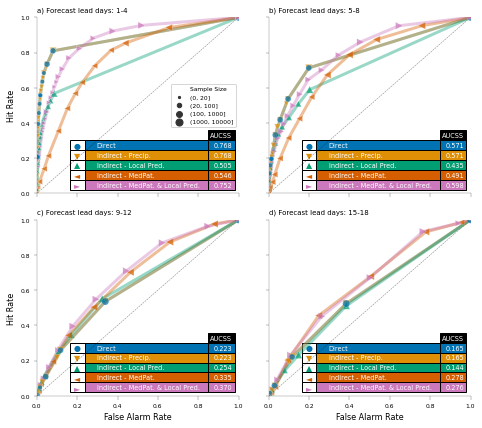

In [59]:
for i_perc, i_name in zip(perc_used, ['Aux7', 'FigA2', 'Aux8']):
    roc_plot('Calabria', i_perc, [3, 7, 11, 17], i_name)
    
del(i_perc, i_name)

In [60]:
def rocs_timeseries(loc_used, used_perc, fig_name_aux):
    
    types_used_final = ['Direct', 'Indirect - Precip.', 'Indirect - Local Pred.', 
                        'Indirect - MedPat.', 'Indirect - MedPat. & Local Pred.']
    
    data_used = reliability_df.query('percentile==@used_perc and WarnArea==-1 and step<=18')
    all_steps = sorted(data_used.step.unique())
     
    rocs_all = []
    for i_step in all_steps:

        rocs_boot = []
        subset_used_all = data_used.query('step==@i_step')

        for boot_i in subset_used_all.bootstrap.unique():

            rocs = pd.DataFrame({'AUCS': np.nan}, index=types_used_final)
            subset_used_boot = subset_used_all.query('bootstrap==@boot_i')

            for i_type in types_used_final:
                subset_used_all_type = subset_used_boot.query('Method==@i_type')
                subset_used_all_type = subset_used_all_type.sort_values('FalseAlarmRate')
                subset_used_all_type = subset_used_all_type.query('FalseAlarmRate>=0')
                rocs_i = 2*np.trapz(subset_used_all_type.HitRate, x=subset_used_all_type.FalseAlarmRate)-1
                rocs.loc[i_type, 'AUCS'] = rocs_i

            rocs['Bootstrap'] = boot_i
            rocs_boot.append(rocs)

        rocs_boot = pd.concat(rocs_boot)
        rocs_boot['Step'] = i_step
        rocs_all.append(rocs_boot)

    rocs_all = pd.concat(rocs_all)
    rocs_all['Method'] = rocs_all.index
    rocs_all.index = range(len(rocs_all))
    rocs_all['Aux'] = np.nan

    color_palette = {i: j for i, j in zip(types_used_final, sns.color_palette()[:len(types_used_final)])}
    markers_used = markers_symbols[:len(types_used_final)]
    
    fig, ax = plt.subplots(1, 1, figsize=(8/2.54, 6.5/2.54))
    sns.pointplot(data=rocs_all.query('Bootstrap=="Q50"'), y='AUCS', x='Step', hue='Method', 
                  markers=markers_used, kind='point', ax=ax)

    range_data = rocs_all.query('Bootstrap in ["Q5", "Q95"]')
    for i_type_ind, i_type in enumerate(types_used_final):
        ax.fill_between(range_data.query('Bootstrap=="Q5" and Method==@i_type').Step,
                        range_data.query('Bootstrap=="Q5" and Method==@i_type').AUCS, 
                        range_data.query('Bootstrap=="Q95" and Method==@i_type').AUCS,
                        color=sns.color_palette()[i_type_ind], alpha=.15)

    ax.axhline(0, linestyle='--', color='black', zorder=-1)
    values_range = rocs_all.query('Step>=@rolling_days')
    ax.set_ylim(np.floor(values_range.AUCS.min()*10)/10, np.ceil(values_range.AUCS.max()*10)/10)
    ax.set_xlim(rolling_days, 18)
    ax.set_xticks(np.arange(rolling_days, 19, 2))
    steps_all = sorted(rocs_all.Step.unique())
    tick_names = [str(int(max(i-rolling_days+1, 0)*1))+'-'+str(int((i+1)*1)) for i in steps_all]
    ax.set_xticklabels(tick_names[rolling_days:19:2], rotation=30)
    ax.set_xlabel('Forecast lead time (days)')
                       
        
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)
    
    fig_name = f'{out_dir}{plots_loc}{loc_used}/{fig_name_aux}'
    fig.subplots_adjust(right=0.95, left=.15, top=.95, bottom=.2) 
    fig.savefig(fig_name+'.png', dpi=600)
    fig.savefig(fig_name+'.pdf', dpi=600)
    if used_perc!=95: plt.close()

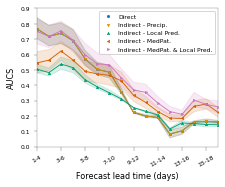

In [61]:
for i_perc, i_name in zip(perc_used, ['Aux9', 'FigA3', 'Aux10']):
    rocs_timeseries('Calabria', i_perc, i_name)
    
del(i_perc, i_name)

In [62]:
def final_ev_values(data_used):
    
    i_xr = data_used.sel(bootstrap=['Q5', 'Q50']) # get data of interest
    
    # mask data for significance and based on sample size
    mask_samples = (i_xr['SampleFrcsts'].sel(bootstrap='Q5')>5) & (i_xr['SampleFrcsts'].sel(bootstrap='Q50')>7)
    mask_values = (i_xr['EV'].sel(bootstrap='Q50')>0) & (i_xr['EV'].sel(bootstrap='Q5')>-0.005)
    mask = mask_samples & mask_values
    
    i_xr = i_xr.sel(bootstrap='Q50').where(mask) # final mask   
    i_xr = i_xr.max('p_thr')
    
    return i_xr['EV']

In [63]:
area_used = 'Calabria'
precip_test = results_all[area_used]['precipERA5']['EV']
precip_test = precip_test.assign_coords({'Predictor': 'Indirect - Precip.'})

precip_act_test = results_all[area_used]['precipForecasts']['EV']
precip_act_test = precip_act_test.assign_coords({'Predictor': 'Direct'})

wvf_dirs = ['NorthW', 'SouthW', 'EastW', 'WestW', 'Total']

wvf_test = results_all[area_used]['wvfERA5']['EV']
wvf = results_all[area_used]['wvfERA5']['Brier'].sel(bootstrap='Q50').reset_coords(drop=True)

wvf_brier_perfect = results_all[area_used]['wvfERA5']['BrierPerfect'].sel(bootstrap="Q50", Constraints=0)
wvf_brier_perfect = wvf_brier_perfect.reset_coords(drop=True)

criterion = []
for i_extra in wvf_brier_perfect.Extra.values:
    if i_extra!='Alone': 
        crit_i = wvf_brier_perfect.sel(Extra=i_extra)
    else:
        crit_i = wvf_brier_perfect.sel(wvf_direction=wvf_dirs, Extra=i_extra)

    criterion.append( crit_i['BSS_clim_Sign'] == crit_i['BSS_clim_Sign'].max('wvf_direction') )

criterion = xr.concat(criterion, dim='Extra')

wvf_brier_perfect = wvf_brier_perfect['BSS_clim'].where(criterion).idxmax('wvf_direction')

rh_ev_single = wvf_test.sel(wvf_direction='RH850', Extra='Alone').drop(['wvf_direction', 'Extra'])
rh_ev_single = rh_ev_single.assign_coords({'Predictor': 'Indirect - RH'})

def subset_wvf(extra_dim):

    final_ind = wvf_brier_perfect.sel(Extra=extra_dim)
    final_subset = []
    for i_p in final_ind.percentile.values:
        subset_perc = [wvf_test.sel(wvf_direction=j, WarnArea=i, Extra=extra_dim, percentile=i_p)\
                       .drop(['wvf_direction', 'Extra'])
                       for i, j in enumerate(final_ind.sel(percentile=i_p).values)]

        final_subset.append(xr.concat(subset_perc, dim='WarnArea'))

    final_subset = xr.concat(final_subset, dim='percentile')
    return final_subset

wvf_ev_single = subset_wvf('Alone').assign_coords({'Predictor': 'Indirect - WVF'})
wvf_ev_combo = subset_wvf('RH850').assign_coords({'Predictor': 'Indirect - Combo'})

wvf = xr.concat([rh_ev_single, wvf_ev_single, wvf_ev_combo], dim='Predictor')

wvf_local = results_all[area_used]['wvfERA5']['Brier'].sel(bootstrap='Q50').reset_coords(drop=True)
best_local = wvf_local.stack(combo=['wvf_direction', 'Extra'])
criterion = best_local['BSS_Sign'] == best_local['BSS_Sign'].max('combo')
best_local = best_local.where(criterion)['BSS'].idxmax('combo')

final_subset = []
for i_p in best_local.percentile.values:
    subset_perc = []
    for i_step in best_local.step.values:
        subset_step = [wvf_test.sel(wvf_direction=j[0], WarnArea=i, Extra=j[1], 
                                    percentile=i_p, step=i_step).drop(['wvf_direction', 'Extra'])
                       for i, j in enumerate(best_local.sel(percentile=i_p, step=i_step).values)]

        subset_perc.append(xr.concat(subset_step, dim='WarnArea'))

    final_subset.append(xr.concat(subset_perc, dim='step'))

final_subset = xr.concat(final_subset, dim='percentile').assign_coords({'Predictor': 'Indirect - Local Pred.'})

wvf_test = xr.concat([wvf, final_subset], dim='Predictor')

med_test = results_all[area_used]['MedPatterns']['EV']
med_test_actual = med_test.isel(wvf_percentile=0, Extra=0, wvf_direction=0)
med_test_actual = med_test_actual.reset_coords(drop='wvf_direction').reset_coords(drop=True)
med_test_actual = med_test_actual.assign_coords({'Predictor': 'Indirect - MedPat.'})

med_combo = med_test.sel(wvf_percentile=1)
best_combo = results_all[area_used]['MedPatterns']['Brier'].sel(wvf_percentile=1)
best_combo = best_combo.sel(bootstrap='Q50').stack(combo=['wvf_direction', 'Extra'])
criterion = best_combo['BSS_Sign'] == best_combo['BSS_Sign'].max('combo')
best_local = best_combo.where(criterion)['BSS'].idxmax('combo')

final_subset = []
for i_p in best_local.percentile.values:
    subset_perc = []
    for i_step in best_local.step.values:
        subset_step = [med_combo.sel(wvf_direction=j[0], WarnArea=i, Extra=j[1], 
                                     percentile=i_p, step=i_step).drop(['wvf_direction', 'Extra'])
                       for i, j in enumerate(best_local.sel(percentile=i_p, step=i_step).values)]

        subset_perc.append(xr.concat(subset_step, dim='WarnArea'))

    final_subset.append(xr.concat(subset_perc, dim='step'))

final_subset = xr.concat(final_subset, dim='percentile').assign_coords({'Predictor': 
                                                                        'Indirect - MedPat. & Local Pred.'})

ref_test = results_all[area_used]['ReferenceConnections']['EV'].max('Method')
ref_test = ref_test.assign_coords({'Predictor': 'Ref. Climat.'})
    
ev_value_xr = [precip_test, precip_act_test, wvf_test, med_test_actual, final_subset, ref_test]
ev_value_xr = xr.concat(ev_value_xr, dim='Predictor')
ev_value_xr = final_ev_values(ev_value_xr)
ev_value_xr = ev_value_xr.assign_coords({'step': ev_value_xr.step/np.timedelta64(1, 'D')})
ev_value_xr = ev_value_xr.reset_coords(drop=True)
ev_value_xr = ev_value_xr.rename({'Predictor': 'Method'})

del(area_used, precip_test, precip_act_test, wvf_dirs, wvf_test, wvf, wvf_brier_perfect, criterion, i_extra, 
    crit_i, rh_ev_single, subset_wvf, wvf_ev_single, wvf_ev_combo, wvf_local, best_local, final_subset, i_p,
    subset_perc, med_test, med_test_actual, med_combo, ref_test)

In [64]:
"""
Because "idxmax" takes 1st in case of equality, order the "Indirect-Precip", before the "Direct". This is due to
the fact that indirect is better because of lower uncertaitnly (BSS plots). In a similar logic, the other methods
are ordered as "Local Pred", "Med Pat", "Met Pat & Local Pred" for having first methods with less subsets on 
the predictors.
"""
types_used_final = ['Indirect - Precip.', 'Direct', 'Indirect - Local Pred.', 
                    'Indirect - MedPat.', 'Indirect - MedPat. & Local Pred.', 'Ref. Climat.']

test_best = ev_value_xr.sel(Method=types_used_final, step=range(rolling_days, 19))
best_predictor = test_best.idxmax('Method')#.fillna('Climatology')
best_predictor.name = 'Method'
test_best = test_best.max('Method')
test_best.name = 'EV_value'
best_predictor = xr.merge([best_predictor, test_best])
best_predictor = best_predictor.to_dataframe().reset_index()
best_predictor['EV'] = pd.cut(best_predictor.EV_value, [0, .1, .3, .6, 1])   
best_predictor['WarnArea_ordered'] = best_predictor.WarnArea.map({i:j for i, j in enumerate(warn_areas_ordered)})

del(test_best)
best_predictor.head()

,WarnArea,percentile,cost_ratio,step,Method,EV_value,EV,WarnArea_ordered
0,0,90,0.001,3.0,NaN,NaN,NaN,4
1,0,90,0.001,4.0,NaN,NaN,NaN,4
2,0,90,0.001,5.0,Indirect - MedPat. & Local Pred.,0.182913,"(0.1, 0.3]",4
3,0,90,0.001,6.0,Indirect - MedPat. & Local Pred.,0.062299,"(0.0, 0.1]",4
4,0,90,0.001,7.0,Indirect - MedPat. & Local Pred.,0.042965,"(0.0, 0.1]",4


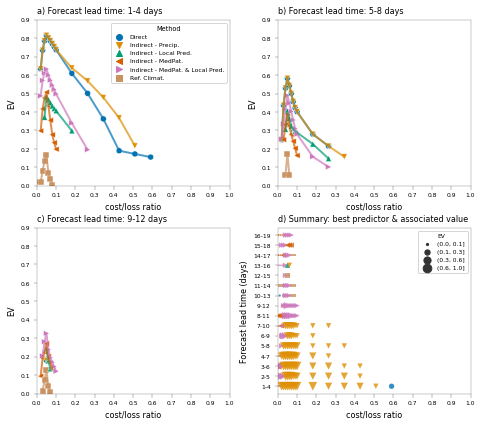

In [65]:
loc_used = 'Calabria'
steps_used = [3, 7, 11]
used_perc = 95
warn_area_used = ev_value_xr.WarnArea.max().values # whole region is always the last warning area

fig, ax = plt.subplots(2, 2, figsize=(18/2.54, 15/2.54))
ax = ax.flatten()

types_used_final = ['Direct', 'Indirect - Precip.', 'Indirect - Local Pred.', 
                    'Indirect - MedPat.', 'Indirect - MedPat. & Local Pred.', 'Ref. Climat.']#[:-1]

color_palette = {i: j for i, j in zip(types_used_final, sns.color_palette()[:len(types_used_final)])}    

final_data = ev_value_xr.sel(WarnArea=warn_area_used, step=steps_used, 
                             percentile=used_perc, Method=types_used_final)
final_data = final_data.to_dataframe().reset_index()

i_count = 0
for i_ax, i_step in zip(ax, steps_used):

    subset_used = final_data.query('step==@i_step')
    aux_plot = subset_used.pivot_table(index='cost_ratio', columns='Method', values='EV', dropna=False)
    aux_plot[types_used_final].plot(legend=False, linewidth=2, alpha=0.7, ax=i_ax)

    sns.scatterplot(data=subset_used, y='EV', x='cost_ratio', hue='Method', style='Method',
                    hue_order=types_used_final, legend=True, palette=color_palette,
                    markers={j:i for i, j in zip(markers_symbols, types_used_final)}, ax=i_ax)

    h, l = i_ax.get_legend_handles_labels()
    if i_step==steps_used[0]:
        i_ax.legend(h[-len(types_used_final):], l[-len(types_used_final):], title='Method', 
                    fontsize=6, title_fontsize=6.5, loc=1)
    else:
        i_ax.get_legend().remove()

    i_ax.set_ylabel('EV')
    i_ax.set_xlabel('cost/loss ratio')
    i_ax.set_ylim(0, np.ceil(final_data.EV.max()*10)/10)
    i_ax.set_xlim(0, 1)
    i_ax.set_xticks(np.arange(11)/10)
    i_ax.set_xticklabels(np.arange(11)/10)

    i_title = f'{subplot_id[i_count]}) Forecast lead time: {int(max(0, i_step-2))}-{int(i_step+1)} days'
    i_ax.set_title(i_title, loc='left', size=8)
    
    i_count += 1

sns.scatterplot(data=best_predictor.query('percentile==@used_perc and WarnArea==@warn_area_used'), 
                x='cost_ratio', y='step', hue='Method', hue_order=types_used_final, palette=color_palette,
                size='EV', sizes=(75, 5), style='Method', edgecolor='none', alpha=0.8,
                markers={j:i for i, j in zip(markers_symbols, types_used_final)}, ax=ax[-1])

h, l = ax[-1].get_legend_handles_labels()
ax[-1].legend(h[len(types_used_final)+1:], l[len(types_used_final)+1:], fontsize=6, title_fontsize=6.5, loc=1)

steps_all = sorted(best_predictor.step.unique())
tick_names = [str(int(max(i-rolling_days+1, 0)*1))+'-'+str(int((i+1)*1)) for i in steps_all]
ax[-1].set_yticks(steps_all)
ax[-1].set_yticklabels(tick_names[:])
    
ax[-1].set_ylabel('Forecast lead time (days)')
ax[-1].set_xlabel('cost/loss ratio')
ax[-1].set_xlim(0, 1)
ax[-1].set_xticks(np.arange(11)/10)
ax[-1].set_xticklabels(np.arange(11)/10)

i_title = f'{subplot_id[i_count]}) Summary: best predictor & associated value'
ax[-1].set_title(i_title, loc='left', size=8)

fig.subplots_adjust(wspace=.25, hspace=.25, right=0.95, left=.10, top=.95, bottom=.07)  
fig_name = f'{out_dir}{plots_loc}{loc_used}/Fig9'
fig.savefig(fig_name+'.png', dpi=600)
fig.savefig(fig_name+'.pdf', dpi=600)

del(loc_used, fig, ax, types_used_final, color_palette, final_data, steps_used, used_perc, i_ax, i_step,
    subset_used, aux_plot, h, l, i_title, i_count, steps_all, tick_names, fig_name, warn_area_used)

In [66]:
def ev_summary_plot(area_used, used_perc, fig_name_aux):
    types_used_final = ['Direct', 'Indirect - Precip.', 'Indirect - Local Pred.', 
                        'Indirect - MedPat.', 'Indirect - MedPat. & Local Pred.', 'Ref. Climat.']#[:-1]
    color_palette = {i: j for i, j in zip(types_used_final, sns.color_palette()[:len(types_used_final)])}    
    warn_area_used = ev_value_xr.WarnArea.max().values # whole region is always the last warning area
    fig = sns.relplot(data=best_predictor.query('percentile==@used_perc and WarnArea!=@warn_area_used'),
                      x='cost_ratio', y='step', hue='Method', hue_order=types_used_final, col_wrap=3, 
                      col='WarnArea_ordered', palette=color_palette, col_order=range(len(warn_areas_ordered)),
                      size='EV', sizes=(75, 5), style='Method', edgecolor='none', alpha=0.8,
                      markers={j:i for i, j in zip(markers_symbols, types_used_final)})

    for i_ind, i_ax in enumerate(warn_areas_ordered[:-1]):
        fig.axes.flatten()[i_ax].set_title('')
        steps_all = sorted(best_predictor.step.unique())
        tick_names = [str(int(max(i-rolling_days+1, 0)*1))+'-'+str(int((i+1)*1)) for i in steps_all]
        fig.axes.flatten()[i_ax].set_yticks(steps_all)
        fig.axes.flatten()[i_ax].set_yticklabels(tick_names[:])
        fig.axes.flatten()[i_ax].set_ylabel('Forecast lead time (days)')
        fig.axes.flatten()[i_ax].set_xlabel('cost/loss ratio')
        fig.axes.flatten()[i_ax].set_xlim(0, 1)
        fig.axes.flatten()[i_ax].set_xticks(np.arange(11)/10)
        fig.axes.flatten()[i_ax].set_xticklabels(np.arange(11)/10)
        
        fig.axes.flatten()[i_ax].text(x=0.99, y=0.95, s=subplot_id[i_ax]+')', va='bottom', ha='right',
                                      transform=fig.axes.flatten()[i_ax].transAxes, size=6)

        ax_sub = inset_axes(fig.axes.flatten()[i_ax], loc=1, width='20%', height='60%')
        domains_used[area_used][0].boundary.plot(color='black', linewidth=.5, ax=ax_sub)
        domains_used[area_used][0].loc[[i_ind]].plot(alpha=.7, color='grey', ax=ax_sub)
        ax_sub.axis('off')

    fig.axes.flatten()[i_ind+1].set_title('')
    fig.axes.flatten()[i_ind+1].axis('off')
    leg = fig._legend
    leg.set_bbox_to_anchor([.94, 0.2])

    fig.fig.subplots_adjust(wspace=.20, hspace=.20, right=0.95, left=.15, top=.95, bottom=.06)  
    fig.fig.set_size_inches(18/2.54, 20/2.54)
    fig_name = f'{out_dir}{plots_loc}{area_used}/{fig_name_aux}'
    fig.fig.savefig(fig_name+'.png', dpi=600)
    fig.fig.savefig(fig_name+'.pdf', dpi=600)
    if used_perc!=95: plt.close()

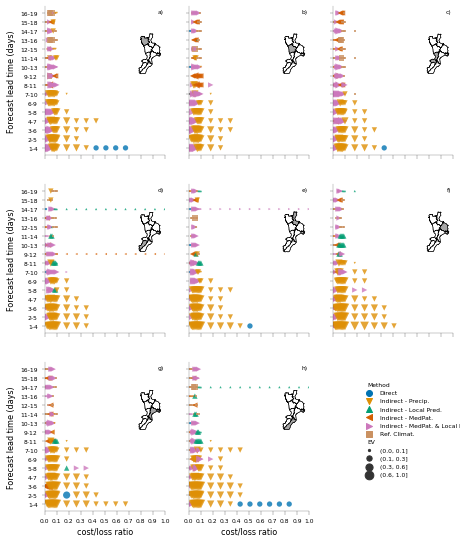

In [67]:
for i_perc, i_name in zip(sorted(reliability_df.percentile.unique()), ['FigS11', 'FigS12', 'FigS13']):
    ev_summary_plot('Calabria', i_perc, i_name)

del(i_perc, i_name)